# Human Diversity Data

This notebook includes getting the human diversity data in shape for the model fitting. 

## Configuration

In [5]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [783]:
from functools import partial
import numpy as np
import scipy.stats as stats
from scipy import interpolate
from scipy.optimize import minimize, curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

from bgspy.genome import Genome
from bgspy.data import GenomeData, get_accessible_from_seqs
from bgspy.data import pi_from_pairwise_summaries

In [7]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200

## Data Loading

In [49]:
autosomes = [f'chr{x}' for x in range(1, 23)]
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=autosomes)
g.load_annot("../data/annotation/conserved_phastcons_thresh0.bed.gz")
g.load_recmap("../data/annotation/hapmap_genetic_map.txt")

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
RecMap._readmap() ignored chrX


In [50]:
gd = GenomeData(g)
gd.load_counts_dir('../data/h1kg/hg1k_counts/')
gd.load_neutral_masks('../data/annotation/neutral_phastcons_genes_with_introns.bed.gz')
gd.load_accessibile_masks('../data/annotation/no_centro.bed')

Fraction neutral, fraction accessible by chromosome:

In [51]:
gd.stats()

{'chr1': (0.6437419477373434, 0.9783094569056748),
 'chr2': (0.5870489628151874, 0.9744006372688843),
 'chr3': (0.6293010576197523, 0.9586475862528016),
 'chr4': (0.5932240306216314, 0.9705595610178201),
 'chr5': (0.5797625887774984, 0.9597880907296792),
 'chr6': (0.5797259005786911, 0.9642869644510512),
 'chr7': (0.6579516885563214, 0.9623460832612318),
 'chr8': (0.6118077615115524, 0.9586602150512149),
 'chr9': (0.6450291885058012, 0.961703740468648),
 'chr10': (0.6283062090688115, 0.9581456808637165),
 'chr11': (0.6352933157215227, 0.9496619287733763),
 'chr12': (0.6272914737717847, 0.9504784490876701),
 'chr13': (0.6201949352598828, 0.9615264647906644),
 'chr14': (0.6542182139077045, 0.9616978924442815),
 'chr15': (0.693987948311888, 0.9509761573619855),
 'chr16': (0.6381502671982755, 0.9435455674996038),
 'chr17': (0.6403107801499688, 0.9195267123331354),
 'chr18': (0.5983902238162843, 0.8992202446372572),
 'chr19': (0.697669622046724, 0.899347663678441),
 'chr20': (0.615711488675

In [52]:
gd.load_fasta('../data/annotation/hg38.fa.gz')

## Chromosome 1 Pairwise Diversity Compared to Other Studies.

Here we focus on megabase-scale variation, as this is the scale to see BGS effects (and it allows us to compare our diversity levels to those of Murphy et al. (2022)).

In [53]:
bins, pi = gd.bin_pi(width=1e6, filter_neutral=True, filter_accessible=True)
bins_alt, pi_alt = gd.bin_pi(width=1e6, filter_neutral=True, filter_accessible=True)

AttributeError: 'BinnedStat' object has no attribute 'sum'

This file is from Murillo Rodrigues forthcoming paper on diversity and divergence across the great apes — it uses data aligned to hg18. Note that I have *not* lifted this over to hg38, so some discrepencies are due to different genomic coordinates.

In [ ]:
dalt = pd.read_csv('../data/all_pidxy_win-size_1000000_merged-mask_True_state_all_curr_all.tsv', sep='\t')
dalt['midpoint'] = (dalt.start + dalt.end)/2
dalt_pi = dalt.loc[(dalt.stat == 'pi') & (dalt.spp1 == 'homo')]

In [ ]:
dalt_pi.head()

This file is from a figure in Murphy et al. (2022) — I digitized this using the web digitizer tool for comparison with our values. This also uses hg18 data so there is some discrepency due to coordinate shifts.

In [ ]:
md = pd.read_csv('../data/murphy_digitized.csv', names=('pos', 'pi'))

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3))

def to_mb(x):
    return x / 1e6

x, y = pi['chr1'].pairs
ax.plot(to_mb(x), y, label='mine filtered')

x, y = pi_alt['chr1'].pairs
ax.plot(to_mb(x), y, label='mine unfiltered')

dalt_pi_chr1 = dalt_pi.loc[dalt_pi.chr == 'chr1']
ax.plot(to_mb(dalt_pi_chr1.midpoint), dalt_pi_chr1.value, label="murillo's")
grid = np.arange(0, 250, 25)
ax.set_xticks(grid)
ax.set_xlabel('position')
ax.set_ylabel('$\pi$')
ax.legend()
ax.grid(linestyle='dashed')

The overall patterns are quite close; Murillo's data is a bit lower as it includes bottlenecked Europeans. Let's take the $\frac{\pi}{\bar{pi}}$ ratio to put these on the same scale:

In [ ]:
def ratio(x):
    return x/np.nanmean(x)

fig, ax = plt.subplots(figsize=(7, 3))

x, y = pi['chr1'].pairs
ax.plot(to_mb(x), ratio(y), label='mine filtered', zorder=3, linewidth=1)

x, y = pi_alt['chr1'].pairs

ax.plot(md['pos'], ratio(md['pi']), label='murphy, digitized', linewidth=1)

dalt_pi_chr1 = dalt_pi.loc[dalt_pi.chr == 'chr1']
ax.plot(to_mb(dalt_pi_chr1.midpoint), ratio(dalt_pi_chr1.value), label="murillo's")
grid = np.arange(0, 250, 25)
ax.set_xticks(grid)
ax.set_xlabel('position')
ax.set_ylabel('$\pi/\\bar{\pi}$')
ax.legend(ncol=2)
ax.grid(linestyle='dashed')

## Genome-Wide Diversity

Let's now look at the data binned data reduction which takes the matrix of allele counts $\mathbf{A}$ ($n_\text{sites} \times 2$ of reference/alt allele counts) and translates this to an equally-dimensioned matrix $\mathbf{Y}$ containing the number of same and different pairwise differences, $\mathbf{Y} = (\mathbf{n_S}, \mathbf{n_D})$. 

Then, pairwise diversity is 

$$\mathbf{\pi} = \frac{\mathbf{n_D}}{\mathbf{n_S} + \mathbf{n_D}}$$

where division is taken element-wise. Note that some windows have inaccessible and NaN or 0 in the data and all chromosomes are concatenated.

In [1224]:
windsize = 1e6

bins, Y = gd.bin_reduce(windsize, merge=True, filter_accessible=True, filter_neutral=True)

Now, let's look at the distribution of $\pi$ across the genome.

In [189]:
def chromplot(midpoint_bins, Y):
    chroms = np.array([int(chrom.replace('chr', '')) for chrom, pos in midpoint_bins])
    mps = np.array([int(pos) for chrom, pos in midpoint_bins])
    x = np.cumsum(mps)
    for chrom in set(chroms):
        idx = chrom == chroms
        pi = pi_from_pairwise_summaries(Y[idx, :])
        plt.plot(x[idx], pi, label=chrom)
    plt.ylabel('$\pi$')
    plt.xlabel('position')

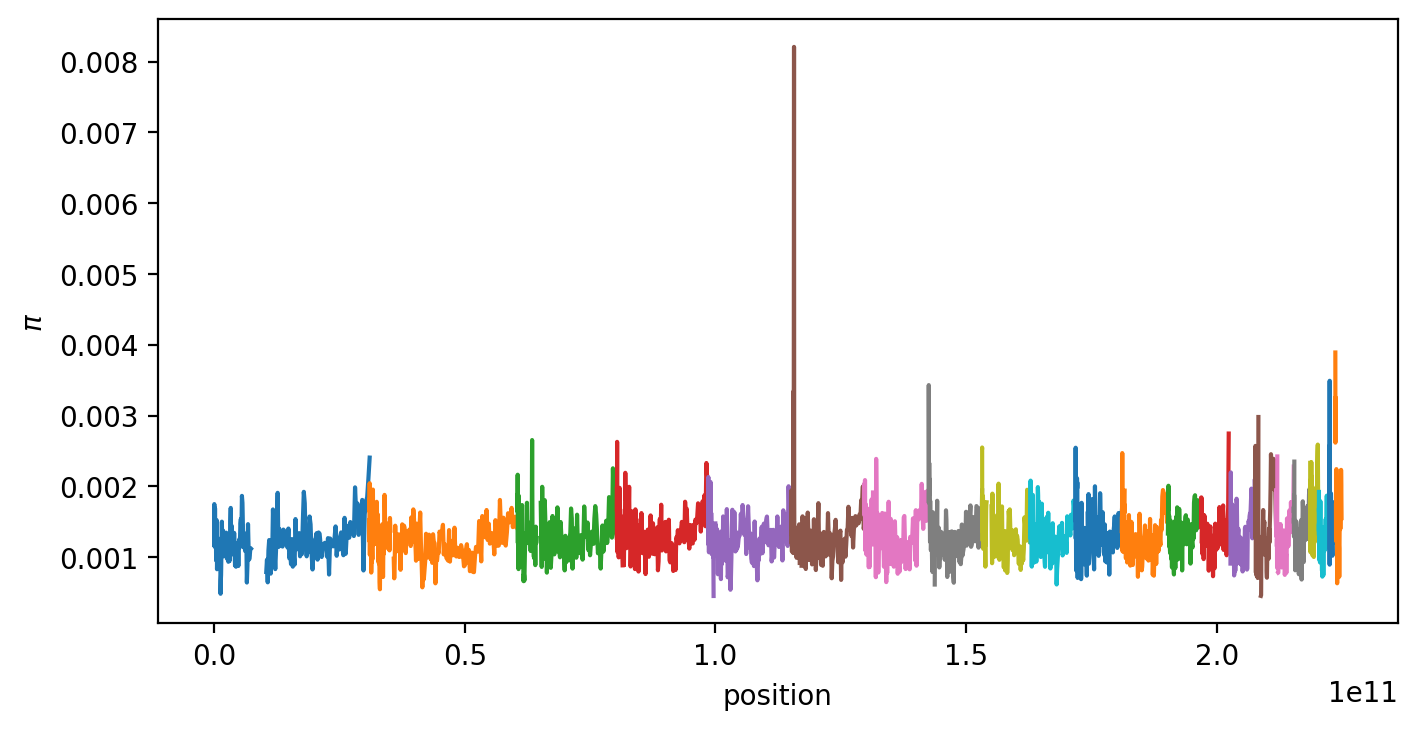

In [190]:
chromplot(bins.flat_midpoints, Y)

Note that there are some extreme outliers. How do these distort the genome-wide distriubtion of $\pi$?

In [892]:
def Y_hist(Y, nbins=100, normal=True):
    """
    Converts Y to π and plots histogram.
    """
    ndiff = Y[:, 1]
    npairs = Y.sum(axis=1)
    pi = np.divide(ndiff, npairs, out=np.full(Y.shape[0], np.nan), 
                   where=npairs > 0)
    _ = plt.hist(pi, nbins, density=True)
    loc, scale = np.nanmean(pi), np.nanstd(pi)    
    if normal:
        z = np.linspace(np.nanmin(pi)*0.99, np.nanmax(pi)*1.01, 1000)
        plt.plot(z, stats.norm(loc=loc, scale=scale).pdf(z), c='r')
    plt.title(f"$\mu={loc:0.4g}, \sigma = {scale:0.4}$")
    plt.xlabel('$\pi$')

In [891]:
np.sqrt(pim*(1-pim) / 1e3**2)

3.637512427828758e-05

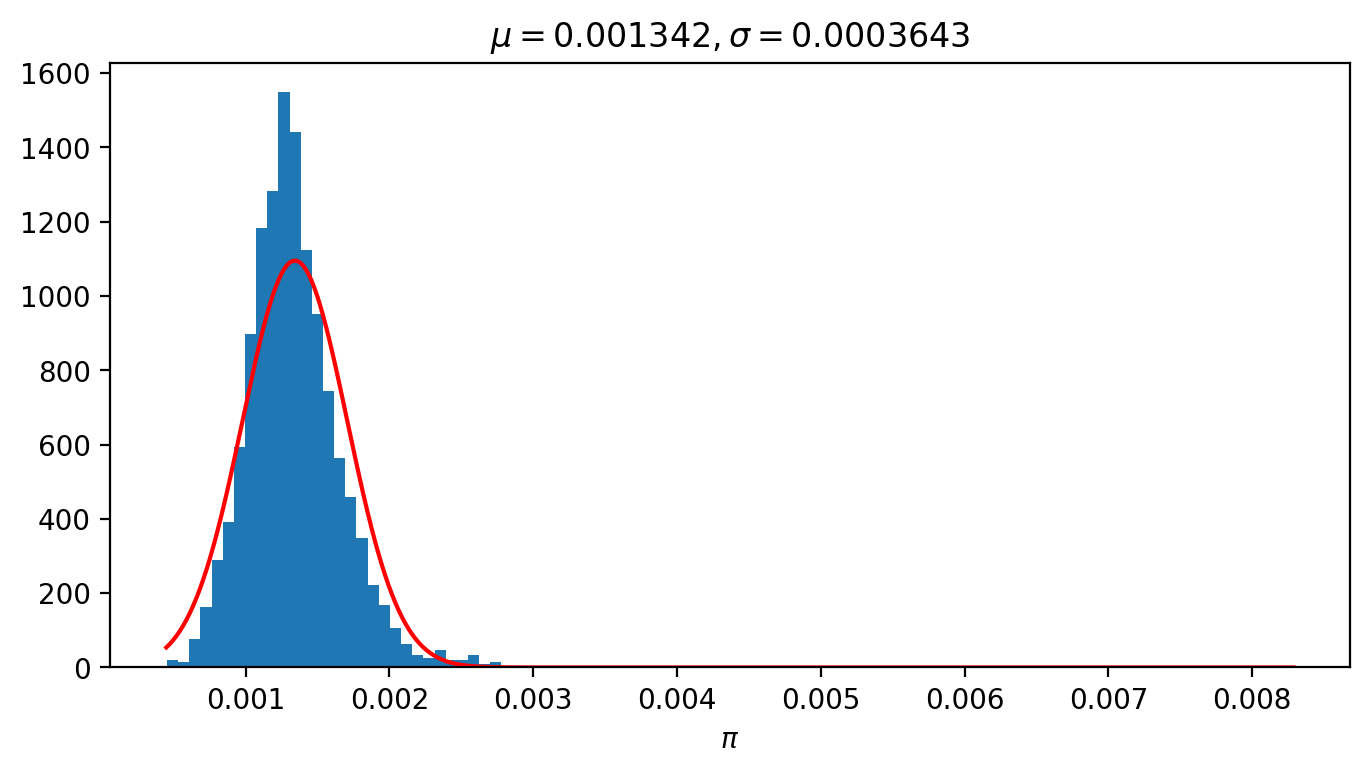

In [199]:
Y_hist(Y)

Let's filter these out by using a trimmed statistic.

In [200]:
def filter_Y(Y, bins, alpha=0.01):
    if isinstance(alpha, float):
        lower, upper = alpha/2, 1-alpha/2
    else:
        lower, upper = alpha
    pi = pi_from_pairwise_summaries(Y)
    idx = (np.nanquantile(pi, lower) < pi) & (np.nanquantile(pi, upper) > pi)
    bins = [b for keep, b in zip(idx, bins.flat) if keep] 
    return bins, Y[idx, :], idx

We'll not trim the left side — only the right.

In [903]:
N = Yf.sum(axis=1).mean()
pim = pi_from_pairwise_summaries(Yf).mean()
pisd = pi_from_pairwise_summaries(Yf).std()

In [904]:
pim, pisd

(0.0013249050396248903, 0.0003004791731114248)

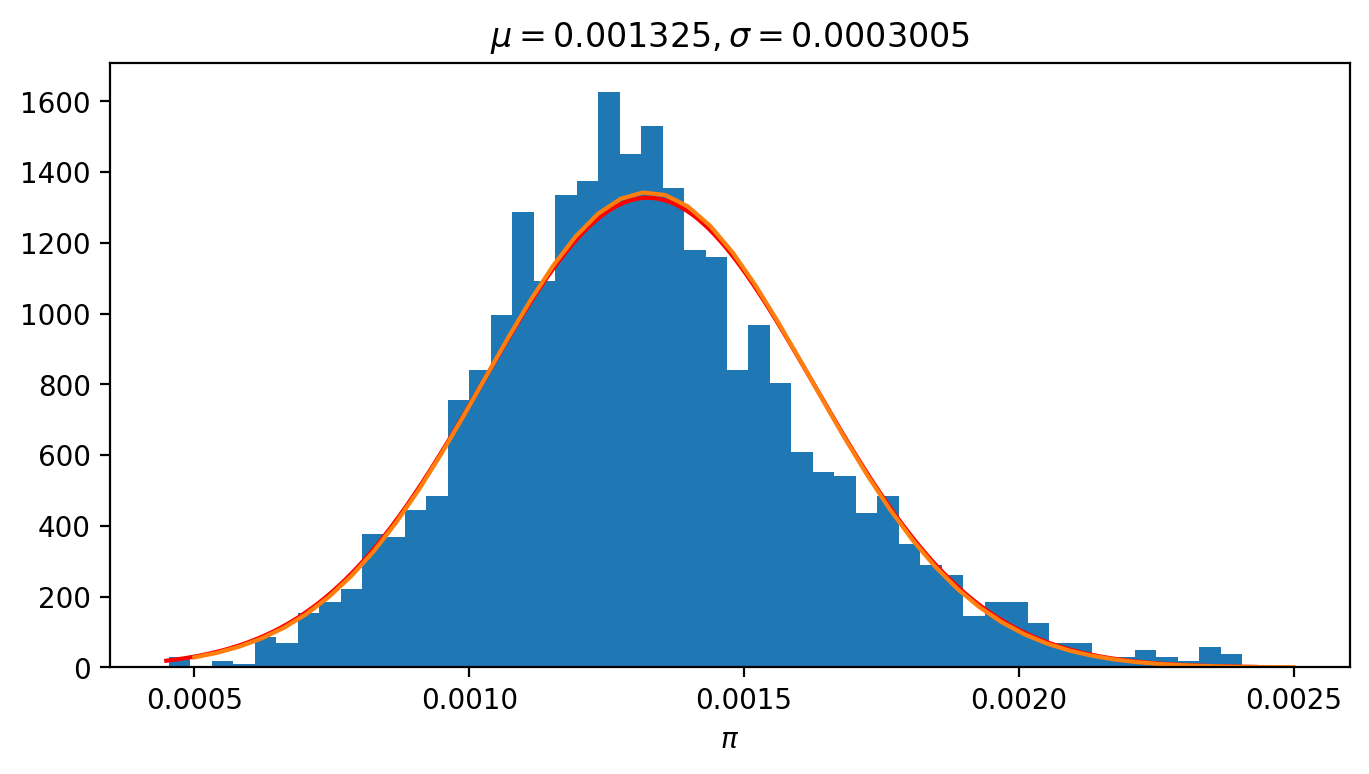

In [941]:
binsf, Yf, idx = filter_Y(Y, bins=bins, alpha=(0.0, 0.99))
Y_hist(Yf, nbins=50)
z = np.linspace(5e-4, 0.00250, 50)
plt.plot(z, stats.norm(loc=pim, scale=np.sqrt(pim*(1-pim)/15000)).pdf(z))

What variance would we expect? If mean diversity is $\bar{\pi}$, the scale is $\sqrt{\bar{\pi} (1-\bar{\pi})}$ per SNP. If we have a genome of $\sim 3 \times 10^9$ with $\bar{pi} \approx 10^{-3}$ SNPs per bp, we're averaging over $\sim 3,000,000$ SNPs. Then the standard deviation under this simple model would be: 

$$
\sigma = \frac{\sqrt{\bar{\pi} (1-\bar{\pi}})}{\sqrt{3 \times 10^6)}}
$$

In [947]:
np.sqrt(1e-3 * 3e9), np.sqrt(pim * (1-pim)) / np.sqrt(1e-3 * 3e9), pisd

(1732.0508075688772, 2.100118779387543e-05, 0.0003004791731114248)

How close is this to a normal?

In [203]:
pi = pi_from_pairwise_summaries(Yf)
z = np.linspace(pi.min(), pi.max(), 100)
loc, scale = stats.norm.fit(pi)
stats.kstest(pi, stats.norm(loc, scale).cdf)

KstestResult(statistic=0.04371953157613173, pvalue=7.863002370395687e-05)

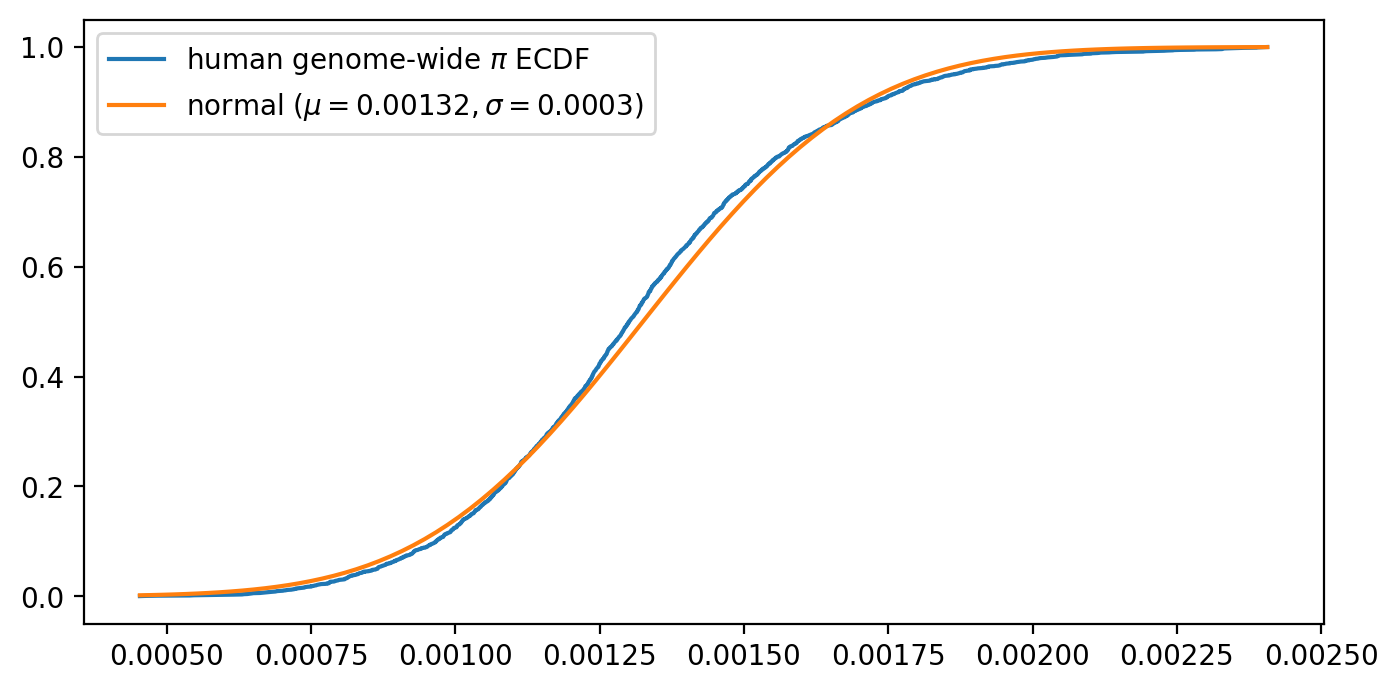

In [204]:
plt.plot(np.sort(pi), (1+np.arange(len(pi)))/len(pi), label='human genome-wide $\pi$ ECDF')
plt.plot(z, stats.norm(*stats.norm.fit(pi)).cdf(z), label=f'normal ($\mu={loc:.3g}, \sigma={scale:.3g}$)')
plt.legend()

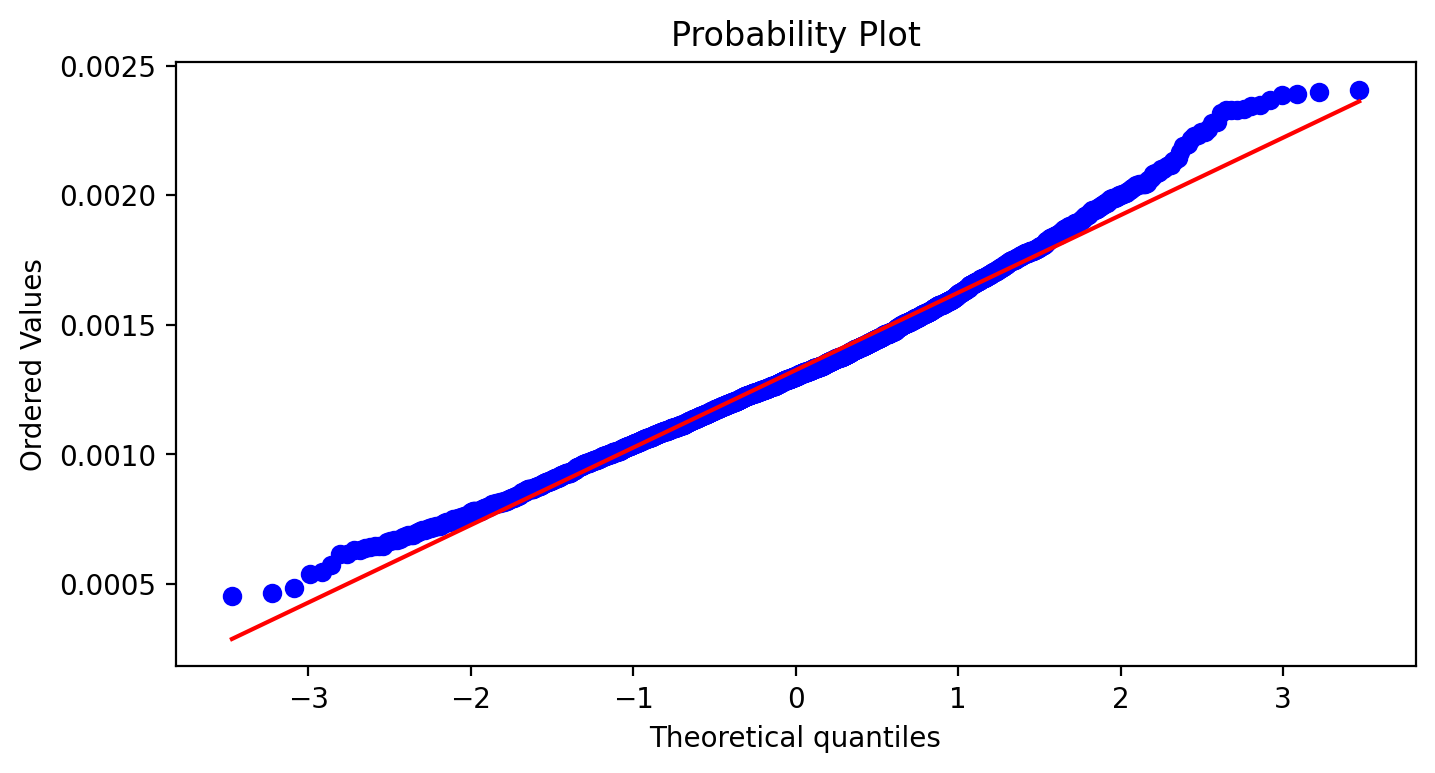

In [205]:
_ = stats.probplot(pi, dist="norm", plot=plt)

Things look a tad distorted. The left tail is a bit thin and the right tail is a bit fat (even after filtering).

In [206]:
# skew and excess kurtosis (Pearson's kurtosis - 3)
stats.skew(pi), stats.kurtosis(pi) - 3

(0.4370890111861593, -2.5854689653735523)

This confirms: excess kurtosis is negative, things are platykurtotic (thin tails). The skew is positive.

Let's look now at the post-trimmed distribution across the genome:

In [207]:
binsf_midpoints = [(c, (start+end)/2) for c, start, end in binsf]

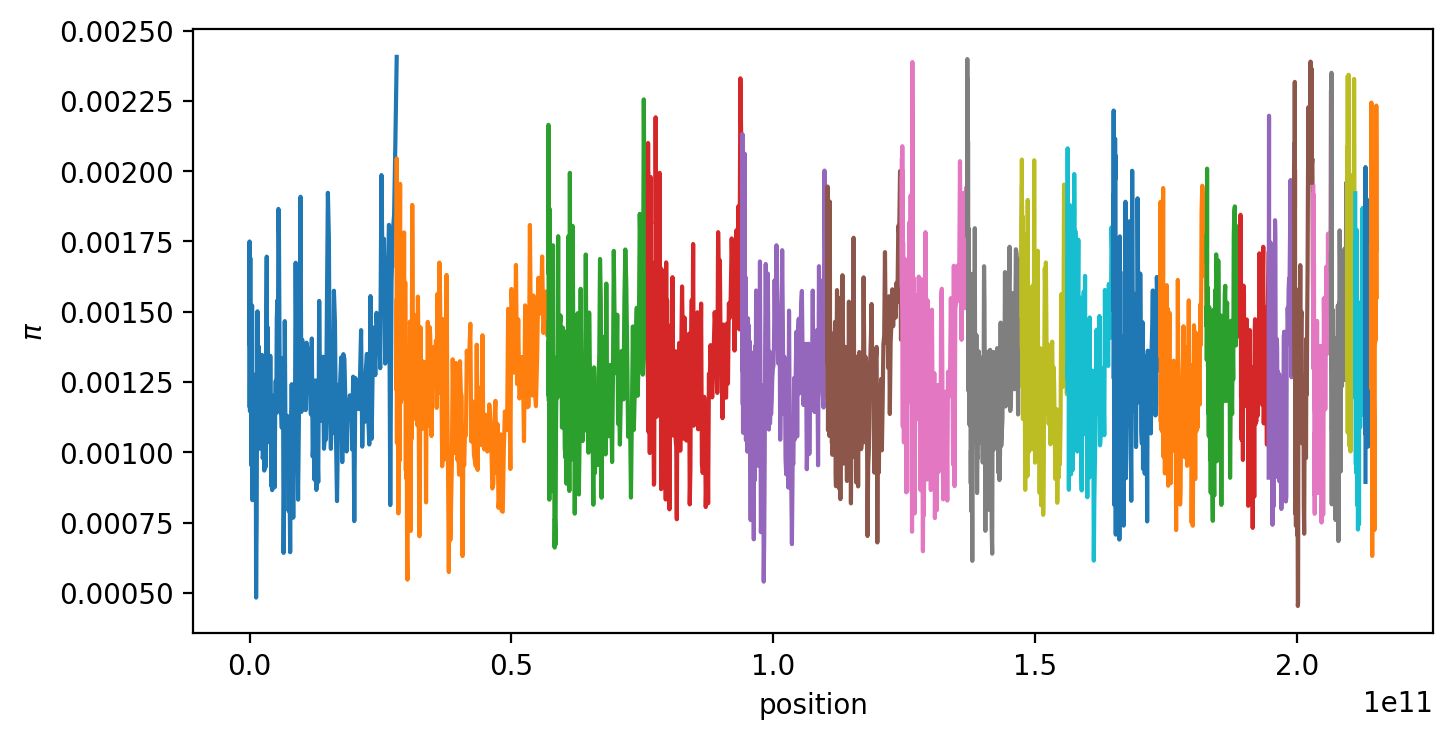

In [208]:
chromplot(binsf_midpoints, Yf)

## Dependencies

Bins are spatially correlated, creating dependencies in the data. We assess and model these here.

Since we reduce data at the megabase bin level, we want to look at the level of autocorrelation/autocovariance at differing levels of bins away using a covariogram. One quick way to do this is

$$g(l) = \mathrm{cov}(i, i+l)$$

where $l$ is the bin index lag. Since recombination rates vary, we also look put this on the natural scale of map position.
 
$$g_m(m) = \mathrm{E}(\mathrm{cov}(i, i+l) | m)$$

TODO: fix above

### Model

We can think about our model as,

$$
\pi(z) = \underbrace{\pi_0 B(z | \theta)}_\text{mean field} + \epsilon(z)
$$

Our error term $\epsilon(z)$ is possible spatially autocorrelated. There exists some empirical covariogram function $\hat{C}(h) = \mathrm{cov}(Y(z), Y(z+h))$ we can estimate from the data directly. However, we are uncertain about both (1) the spatial scale of $\hat{C}(h)$ and (2) whether the dependency is caused by autocorrelation in the mean field $B(z)$ or the error term $\epsilon(z)$. Here, $\epsilon(z)$ includes sampling processes and random genetic drift around the mean field.

We can determine (1) directly from the empirical data. For (2), it is trickier — the clearest way is to generate Monte Carlo realizations of $\pi(z)$ under the neutral process and the sampling process and measure the spatial scale of $C(h)$ (we do this at the very end).


Since mutation is a Poisson point process along the chromosome, we must define the scale at which we measure it.

The bigger question is whether we model the covariance structure, regardless of its source, when trying to estimate $\theta$ from $\pi(z)$. Fundamentally, a composite likelihood assumes independence between binned measurements of $\pi(z)$ — in the case of learning $\theta)$, we want to *discount* nearby observations by some amount because they're not telling us independent bits of information about $\theta$, but rather looking at the same section of $B(z | \theta)$. Thus, we want to control for the total autocovariance. Note that this parallels some debate about what we are controlling for in phylogenetic comparative methods, as well as causal literature. However in this latter case, note that we're not really "controlling" for things in the same way, as we're modeling covariance, not fixed or random effects.

Another way to think about this is: if we generate a random process under $B(z | \theta)$, do we get better inferences if we control for covariance between observations?

One thing is that the mean field itself is *random*, and in this sense, it does make sense to downweight neighboring observations.

In [252]:
# the interface to non-chromosome spanning (e.g. filtered) bins is a bit clunky, hence these:

def midpointbins_to_mapbins(bins):    
    return [(c, float(g.recmap.lookup(c, p, cummulative=True))) for c, p in bins.flat_midpoints]

def bins_to_mapbins(bins):    
    return [(c, float(g.recmap.lookup(c, (s+e)/2, cummulative=True))) for c, s, e in bins]

Whole genome π covariance (note this is an approximation since lags across chromosomes are included).

In [226]:
pi_chroms = np.array([c for c, _, _ in binsf])

Text(0.5, 1.0, 'cov(i, i-1) = 3.308e-08, var(i-1, i-1) = 6.887e-08, var(i, i) = 6.887e-08')

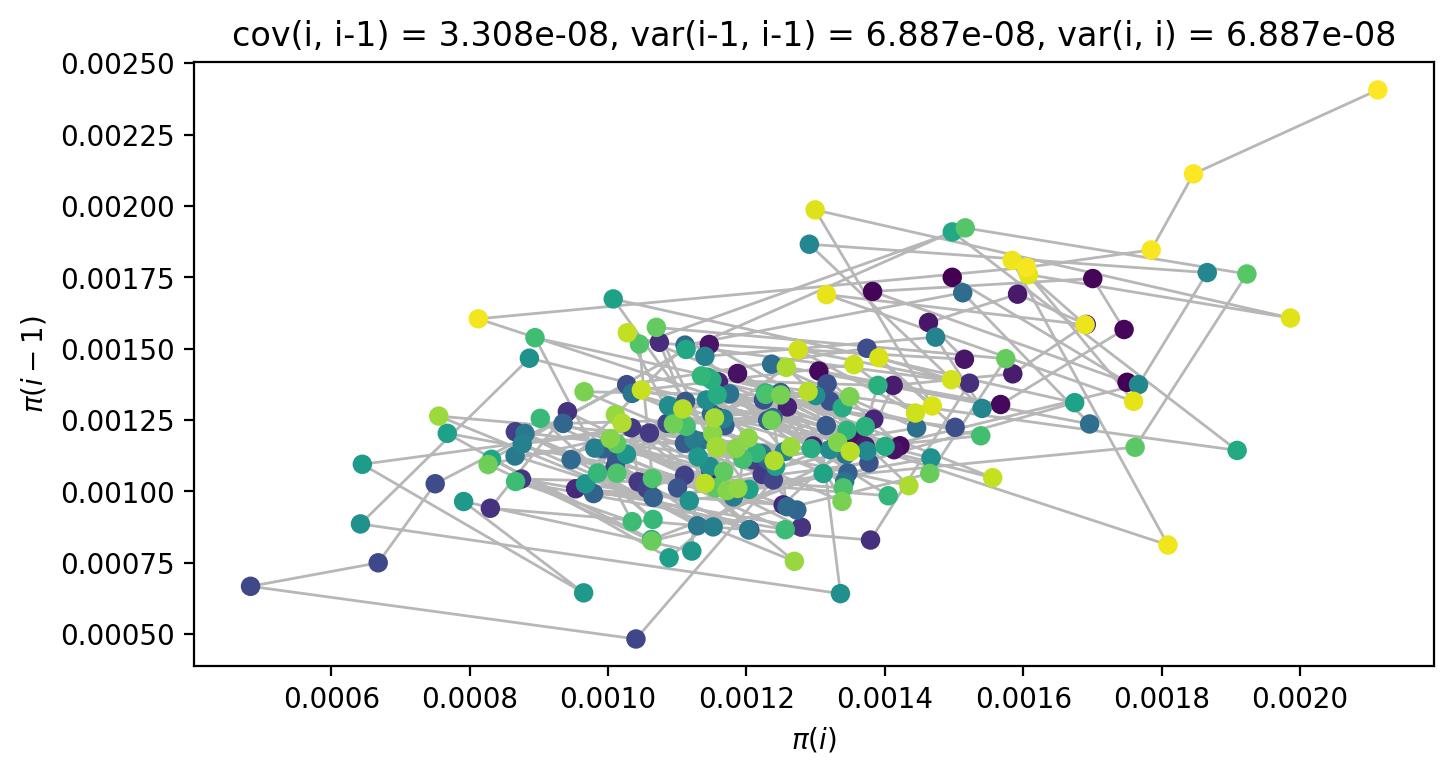

In [227]:
idx2 = pi_chroms == 'chr1'
lag = 1
xpi = pi[idx2]
p1, p2 = xpi[:-(lag)], xpi[(lag):]

plt.plot(p1, p2, linewidth=1, c='0.44', alpha=0.5)
plt.scatter(p1, p2, c=np.arange(len(xpi[(lag):])), zorder=3)
plt.xlabel('$\pi(i)$')
plt.ylabel('$\pi(i-1)$')
#plt.scatter(pi[:-1], pi[1:], c=pi[1:], zorder=3)
cov = np.cov(p1, p2)
plt.title(f"cov(i, i-1) = {cov[0, 1]:.4}, var(i-1, i-1) = {cov[0, 0]:.4}, var(i, i) = {cov[0, 0]:.4}")

Is this first-order covariance significant? Let's do a permutation test:

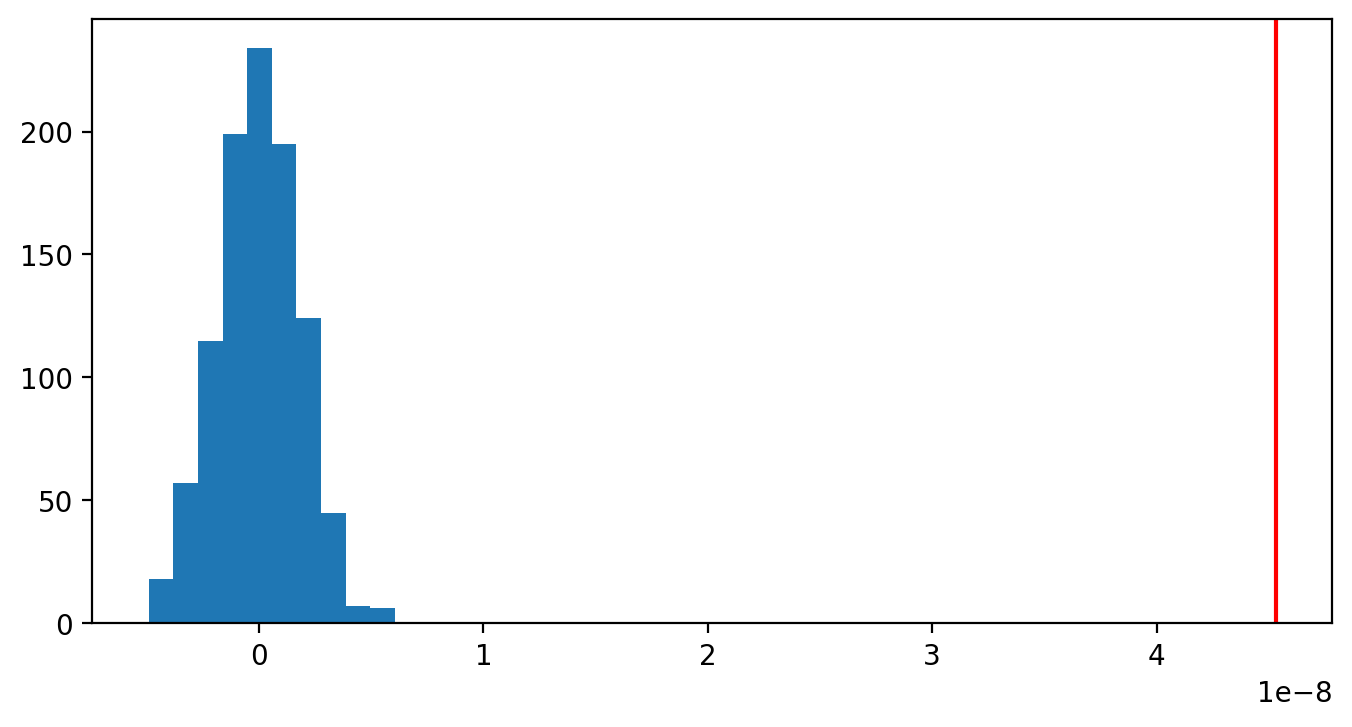

In [230]:
nperms = 1000
null = np.zeros(nperms)
for i in range(nperms):
    null[i] = np.cov(p1, np.random.permutation(p2))[0, 1]

plt.hist(null)
plt.axvline(np.cov(p1, p2)[0, 1], c='r')

## Binned Variograms

In [784]:
def binned_funcgram(y, chroms, positions, max_lag=50, min_n = 3):
    lags = list(range(1, max_lag))
    
    stats = []
    lags = []
    ns = []

    all_chroms = list(set(chroms))
    
    # things are done at the per-chrom level so that we don't get lag runover
    for chrom in all_chroms:
        idx = chroms == chrom
        y_chrom = y[idx]
        x_chrom = positions[idx]

        chrom_stats = []
        chrom_lag = []
        for lag in lags:
            # first, we average/bin the distance for this shifted window lag
            d = np.abs(x[:-lag] - x[lag:]).mean()
            y1, y2 = y_chrom[:-lag], y_chrom[lag:]
            if y2.size < min_n or y1.size < min_n:
                chrom_stats.append(np.nan)
                chrom_lag.append(d)
                continue
            
            stat = func(y1, y2)
            chrom_stats.append(stat)
            chrom_ns.append(np.sum(~np.isnan(x)))
            chrom_lag.append(d)
        stats.append(chrom_stats)
        lags.append(chrom_lag)
    return np.stack(mlags).T, np.stack(covs).T, all_chroms

def chromosome_variogram2(Y, bins, counts=False, cov=False, min_n = 3):
    lags = list(range(1, 50))
    mlags = []
    covs = []
    ns = []
    xchroms = []
    
    chroms = np.array([c for c, _ in bins])
    mpos = np.array([m for _, m in bins])

    all_chroms = list(set(chroms))
    # things are done at the per-chrom level so that we don't get lag runover
    for chrom in all_chroms:
        idx = chroms == chrom
        y = Y[idx, :]
        x = mpos[idx]
        pi = np.true_divide(y[:, 1], y.sum(axis=1), out=np.full(y.shape[0], np.nan), where=y.sum(axis=1) > 0)
        #pi = pi * y.sum(axis=1)
        if counts:
            pi  = pi * y.sum(axis=1)
        pi = pi[~np.isnan(pi)]
        chrom_covs = []
        map_lag = []
        for lag in lags:
            p1, p2 = pi[:-lag], pi[lag:]
            if p2.size < min_n or p1.size < min_n:
                chrom_covs.append(np.nan)
                d = np.nan
                map_lag.append(d)
                continue
            d = np.abs(x[:-lag] - x[lag:]).mean()
            if cov:
                chrom_covs.append(np.cov(p1, p2)[0, 1])
            else:
                chrom_covs.append(((p1-p2)**2).mean())
            map_lag.append(d)
        covs.append(chrom_covs)
        mlags.append(map_lag)
    return np.stack(mlags).T, np.stack(covs).T, all_chroms

In [1338]:
def genomic_funcgram(y, chroms, pos, func=lambda x, y: (x-y)**2, max_lag=50, min_n=3):
    lags = list(range(1, max_lag))
    xlags = []
    res = []
    ns = []
    xchroms = []
    seqs = []
    if not isinstance(chroms, np.ndarray):
        chroms = np.array(chroms)
    if not isinstance(pos, np.ndarray):
        pos = np.array(pos)
    dat = dict()
    all_chroms = list(set(chroms))
    # things are done at the per-chrom level so that we don't get lag runover
    for chrom in all_chroms:
        idx = chroms == chrom
        y_chrom = y[idx]
        pos_chrom = pos[idx]    
        
        chrom_res = []
        x_dist = []
        for lag in lags:
            y1, y2 = y_chrom[:-lag], y_chrom[lag:]
            d = np.abs(pos_chrom[:-lag] - pos_chrom[lag:]).tolist()
            stat = func(y1, y2).tolist()
            chrom_res.extend(stat)
            x_dist.extend(d)
        res.extend(chrom_res)
        xlags.extend(x_dist)
        seqs.extend([chrom] * len(x_dist))
        dat[chrom] = (x_dist, chrom_res)
    return dat #seqs, xlags, res

def bin_funcgram(x, bins):
    out = dict()
    for chrom, (lag, stat) in x.items():
        res = stats.binned_statistic(lag, stat, np.nanmean, bins=bins)
        counts = stats.binned_statistic(lag, stat, lambda x: np.sum(~np.isnan(x)), bins=bins)
        midpoints = (res.bin_edges[1:] + res.bin_edges[:-1])/2
        out[chrom] = (midpoints, res.statistic, counts.statistic)
    return out

In [1353]:
chroms, positions = zip(*map_bins)
chroms = np.array(chroms)
positions = np.array(positions)
#pos = positions[chroms == 'chr1']
#pi = pi[chroms == 'chr1']

map_positions = []
for chrom in set(chroms):
    map_positions.extend(g.recmap.lookup(chrom, positions[chroms == chrom], cummulative=True))

In [1355]:
pi = pi_from_pairwise_summaries(Y)
tmp = genomic_funcgram(pi, chroms, map_positions)

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:665: RuntimeWarning: Mean of empty slice
  result[vv, i] = stat_func(np.array(bin_map[i]))
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:665: RuntimeWarning: Mean of empty slice
  result[vv, i] = stat_func(np.array(bin_map[i]))
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:665: RuntimeWarning: Mean of empty slice
  result[vv, i] = stat_func(np.array(bin_map[i]))
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:665: RuntimeWarning: Mean of empty slice
  result[vv, i] = stat_func(np.array(bin_map[i]))
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/stats/_binned_statistic.py:665: RuntimeWarning: Mean of empty slice
  result[vv, i] = stat_func(np.array(bin_map[i]))
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/stats/_b

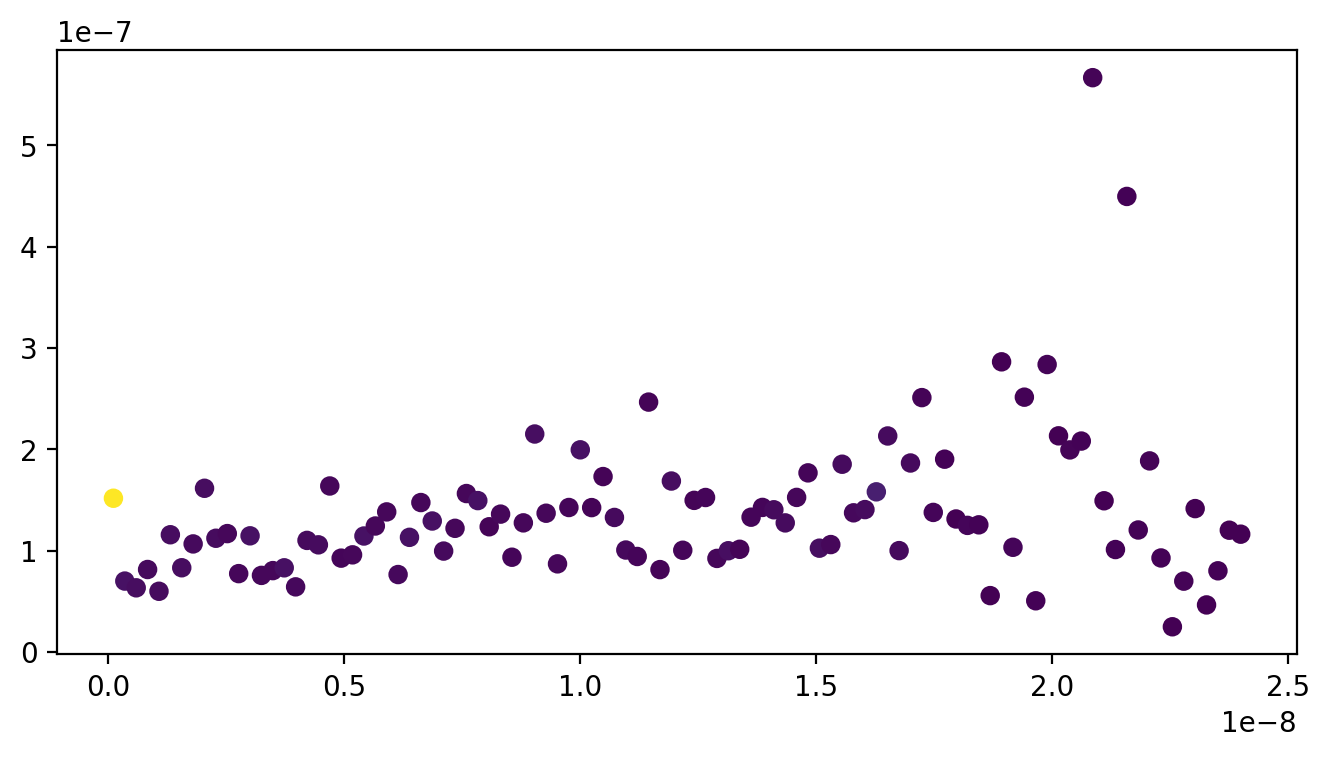

In [1356]:
res = bin_funcgram(tmp, 100)['chr10']
plt.scatter(res[0], res[1], c=res[2])
#plt.ylim(0, 2e-7)

In [1357]:
map_positions

[1.2040872068556053e-10,
 2.643058732180992e-10,
 5.256512244193783e-10,
 8.340218277370527e-10,
 9.864459460918545e-10,
 1.1822964714352751e-09,
 1.4479455448074998e-09,
 1.643227533765795e-09,
 1.8796981012681178e-09,
 1.945870825583683e-09,
 2.036279280287371e-09,
 2.2721982344850356e-09,
 2.540666026633075e-09,
 2.7324874333849317e-09,
 2.8083031875772453e-09,
 2.878156285929476e-09,
 2.9584407320993523e-09,
 3.05309584240068e-09,
 3.197284556884879e-09,
 3.381785190316241e-09,
 3.6834685091850837e-09,
 3.991095531094445e-09,
 4.099620385787578e-09,
 4.190615198112544e-09,
 4.317127817160545e-09,
 4.50697688275537e-09,
 4.593792784250527e-09,
 4.676655227749647e-09,
 4.707328967697274e-09,
 4.756046734734924e-09,
 4.8307972989468455e-09,
 4.875900801229391e-09,
 5.0106343000446365e-09,
 5.0999127433227504e-09,
 5.289872323523682e-09,
 5.496444180724412e-09,
 5.736013385486427e-09,
 5.854527715875586e-09,
 5.908496650663831e-09,
 5.951440881290542e-09,
 6.062414162266919e-09,
 6.141

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


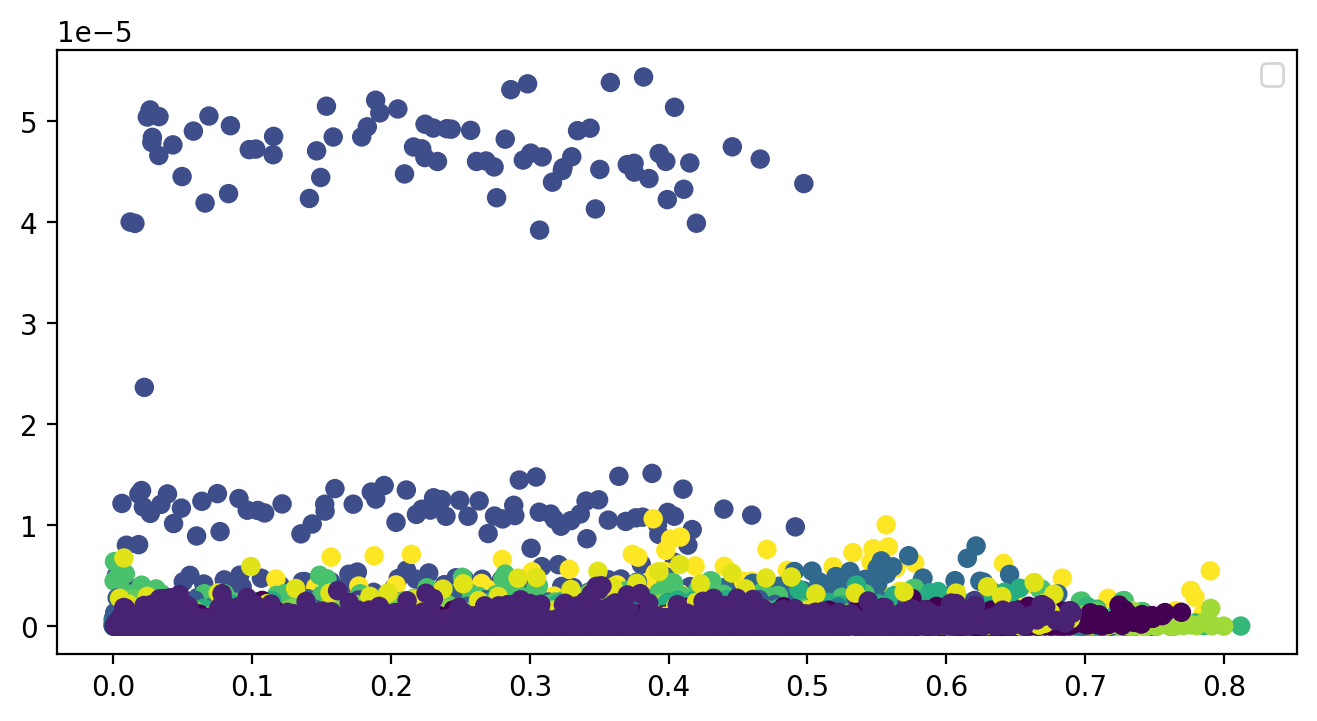

In [1313]:
plt.scatter(tmp[1], tmp[2], c=[int(x.replace('chr', '')) for x in tmp[0]])

In [1283]:
#plt.scatter(tmp[1], tmp[2], c=tmp[0])

In [1350]:
g.recmap

In [1306]:
from scipy.spatial.distance import pdist, squareform

(pi[1:] - pi[:-1])
squareform(pdist(pos[:, None], 'seuclidean'))

array([[0.        , 0.02259009, 0.04455205, ..., 3.70908123, 3.72507391,
        3.74912417],
       [0.02259009, 0.        , 0.02196197, ..., 3.68649114, 3.70248382,
        3.72653408],
       [0.04455205, 0.02196197, 0.        , ..., 3.66452918, 3.68052186,
        3.70457212],
       ...,
       [3.70908123, 3.68649114, 3.66452918, ..., 0.        , 0.01599268,
        0.04004294],
       [3.72507391, 3.70248382, 3.68052186, ..., 0.01599268, 0.        ,
        0.02405026],
       [3.74912417, 3.72653408, 3.70457212, ..., 0.04004294, 0.02405026,
        0.        ]])

First, the unfiltered data. Remember, the lag is always a bin shift lag, which is then translated to a map distance (between midpoints).

Text(0.5, 0, 'map distance (Morgans)')

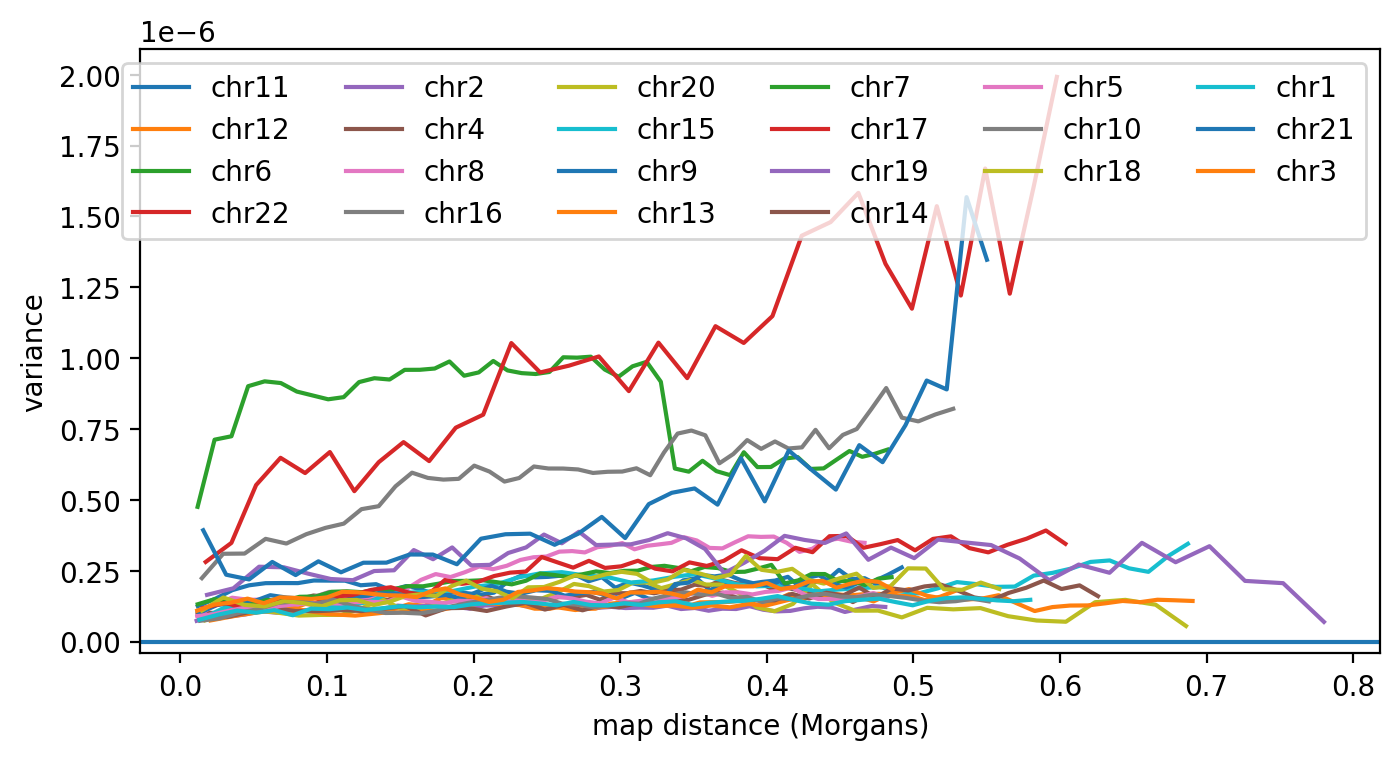

In [787]:
map_bins = midpointbins_to_mapbins(bins)

mlags, covs, covchroms = chromosome_variogram(Y, map_bins)
_ = plt.plot(mlags, covs, label=covchroms)
plt.axhline(0)
plt.legend(ncol=6)
plt.ylabel("variance")
plt.xlabel("map distance (Morgans)")

Text(0.5, 0, 'map distance (Morgans)')

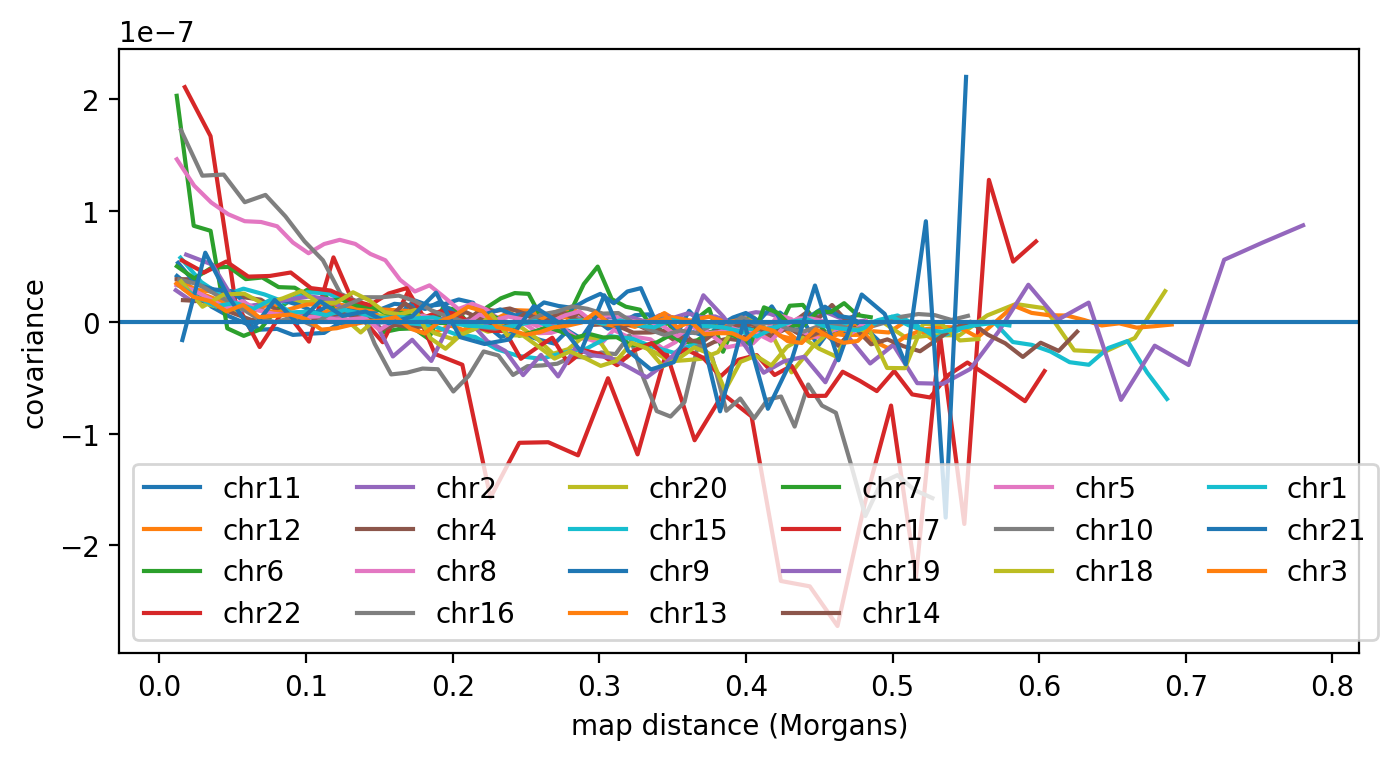

In [788]:
map_bins = midpointbins_to_mapbins(bins)

mlags, covs, covchroms = chromosome_variogram(Y, map_bins, cov=True)
_ = plt.plot(mlags, covs, label=covchroms)
plt.axhline(0)
plt.legend(ncol=6)
plt.ylabel("covariance")
plt.xlabel("map distance (Morgans)")

How does the filtered data look?

Text(0.5, 0, 'map distance (Morgans)')

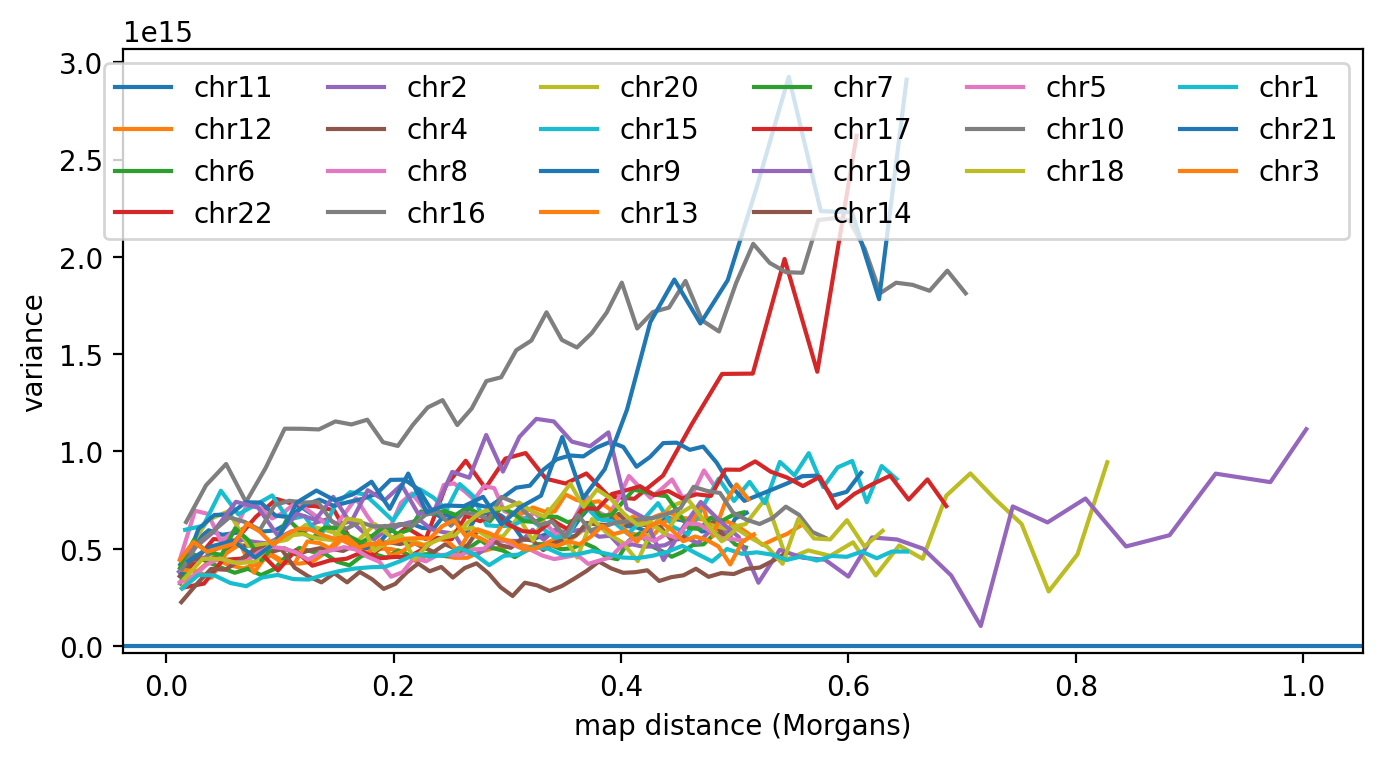

In [873]:
map_binsf = bins_to_mapbins(binsf)

mlags, covs, covchroms = chromosome_variogram(Yf, map_binsf, counts=True)
_ = plt.plot(mlags, covs, label=covchroms)
plt.axhline(0)
plt.legend(ncol=6)
#plt.semilogx()
plt.ylabel("variance")
plt.xlabel("map distance (Morgans)")

Text(0.5, 0, 'map distance (Morgans)')

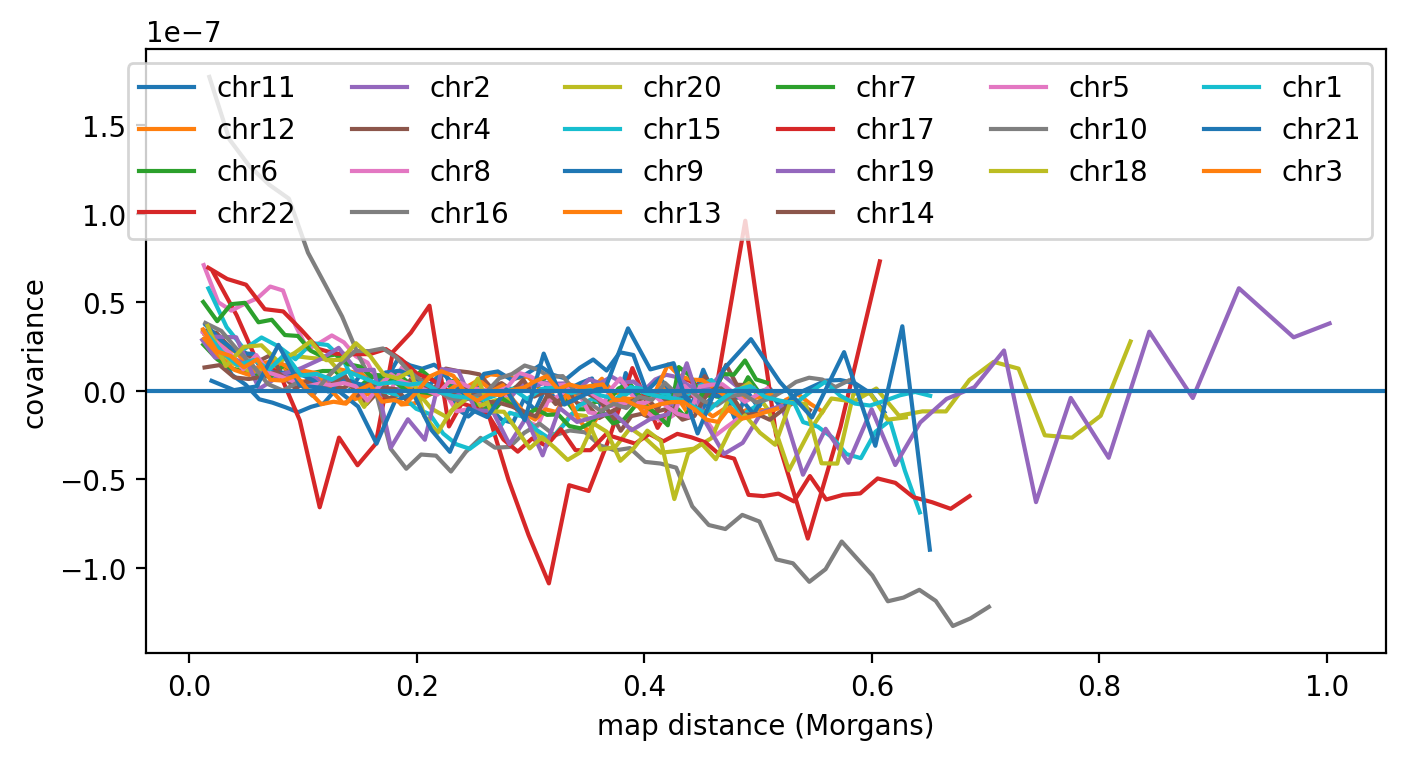

In [870]:
map_binsf = bins_to_mapbins(binsf)

mlags, covs, covchroms = chromosome_variogram(Yf, map_binsf, cov=True)
_ = plt.plot(mlags, covs, label=covchroms)
plt.axhline(0)
plt.legend(ncol=6)
plt.ylabel("covariance")
plt.xlabel("map distance (Morgans)")

Now let's bootstrap the diversity covariogram at the chromosome level:

Text(0, 0.5, 'covariance')

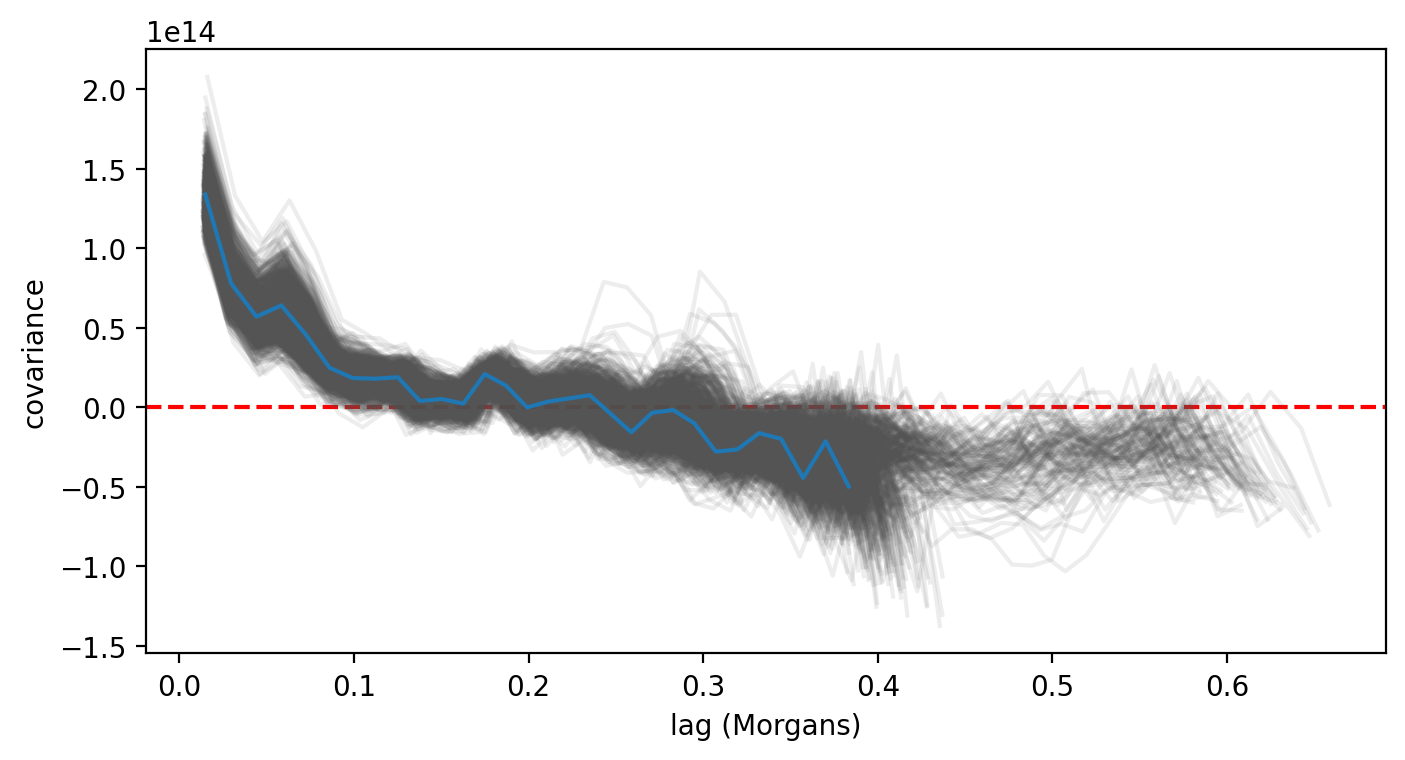

In [795]:
# Note: we have to model the kernel at the counts level (π(x) N(x)) since
# this is going to the normal approximation model
mlags, covs, covchroms = chromosome_variogram(Yf, map_binsf, cov=True, counts=True)

M = covs.T
P = mlags.T
bs = []
ms = []
stat = np.mean
for i in range(1000):
    idx = np.random.randint(0, M.shape[0], M.shape[0])
    bs.append(stat(M[idx, :], axis=0))
    ms.append(stat(P[idx, :], axis=0))
    
_ = plt.plot(np.stack(ms).T, np.stack(bs).T, c='0.33', alpha=0.1)
plt.axhline(0, linestyle='dashed', c='r', zorder=-10)
plt.plot(stat(P, axis=0), stat(M, axis=0))
plt.xlabel('lag (Morgans)')
plt.ylabel('covariance')

Text(0, 0.5, 'covariance')

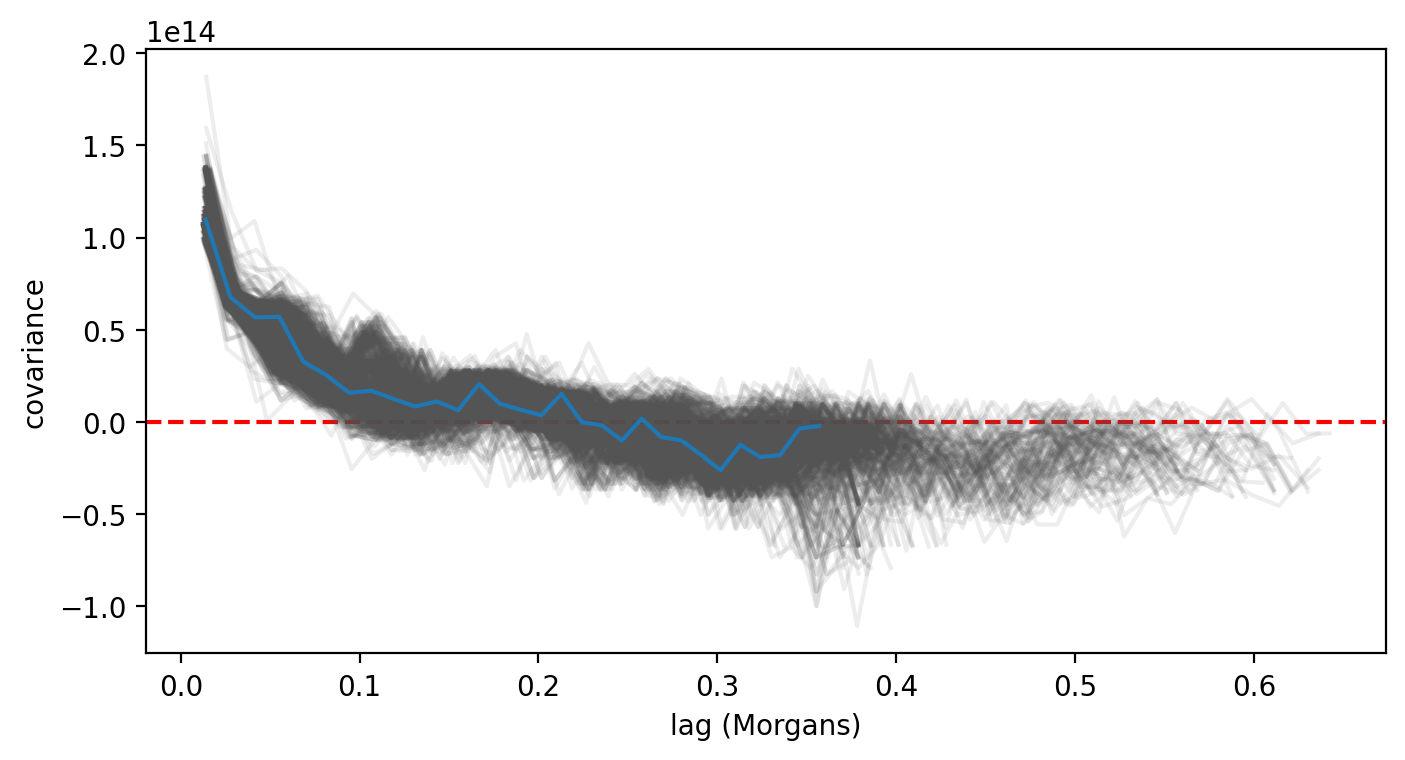

In [796]:
M = covs.T
P = mlags.T
bs = []
ms = []
stat = np.median
for i in range(1000):
    idx = np.random.randint(0, M.shape[0], M.shape[0])
    bs.append(stat(M[idx, :], axis=0))
    ms.append(stat(P[idx, :], axis=0))
    
_ = plt.plot(np.stack(ms).T, np.stack(bs).T, c='0.33', alpha=0.1)
plt.axhline(0, linestyle='dashed', c='r', zorder=-10)
plt.plot(stat(P, axis=0), stat(M, axis=0))
plt.xlabel('lag (Morgans)')
plt.ylabel('covariance')

Text(0, 0.5, 'covariance')

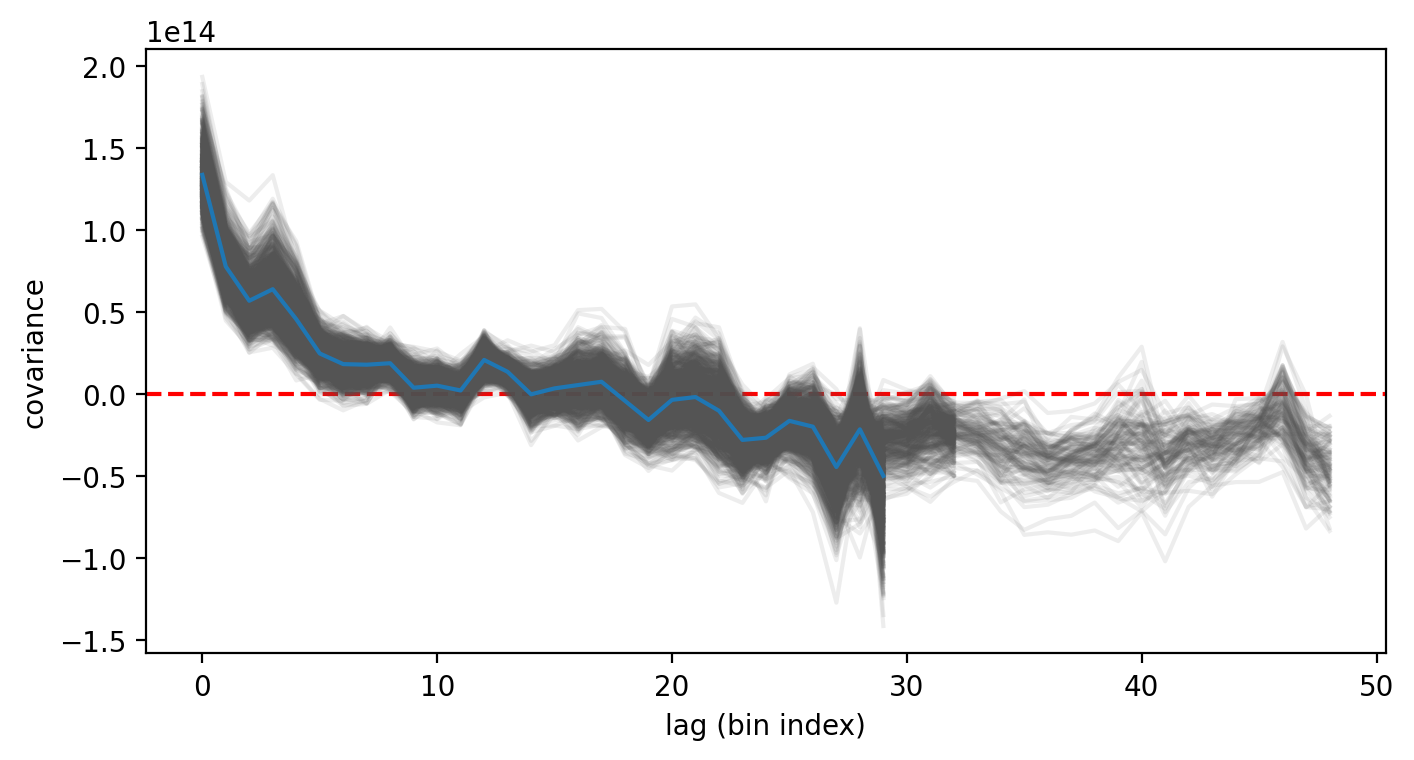

In [797]:
bs = []
for i in range(1000):
    idx = np.random.randint(0, M.shape[0], M.shape[0])
    bs.append(M[idx, :].mean(axis=0))
    
_ = plt.plot(np.stack(bs).T, c='0.33', alpha=0.1)
plt.axhline(0, linestyle='dashed', c='r', zorder=-10)
plt.plot(M.mean(axis=0))
plt.xlabel('lag (bin index)')
plt.ylabel('covariance')

## Parametric Fitting of the Kernel

Let us fit a simple decay kernel

In [798]:
@np.vectorize
def squared_exponential(d, alpha, rho, bias=0):
    # one dimensional
    d = np.abs(d)
    return alpha**2 * np.exp(-0.5 * d**2/rho) + bias

@np.vectorize
def exponential(d, alpha, rho, bias=0):
    # one dimensional
    d = np.abs(d)
    return alpha**2 * np.exp(-0.5 * d/rho) + bias

In [799]:
x, y = np.mean(P, axis=0), np.mean(M, axis=0)
x, y = x[~np.isnan(x)], y[~np.isnan(y)]

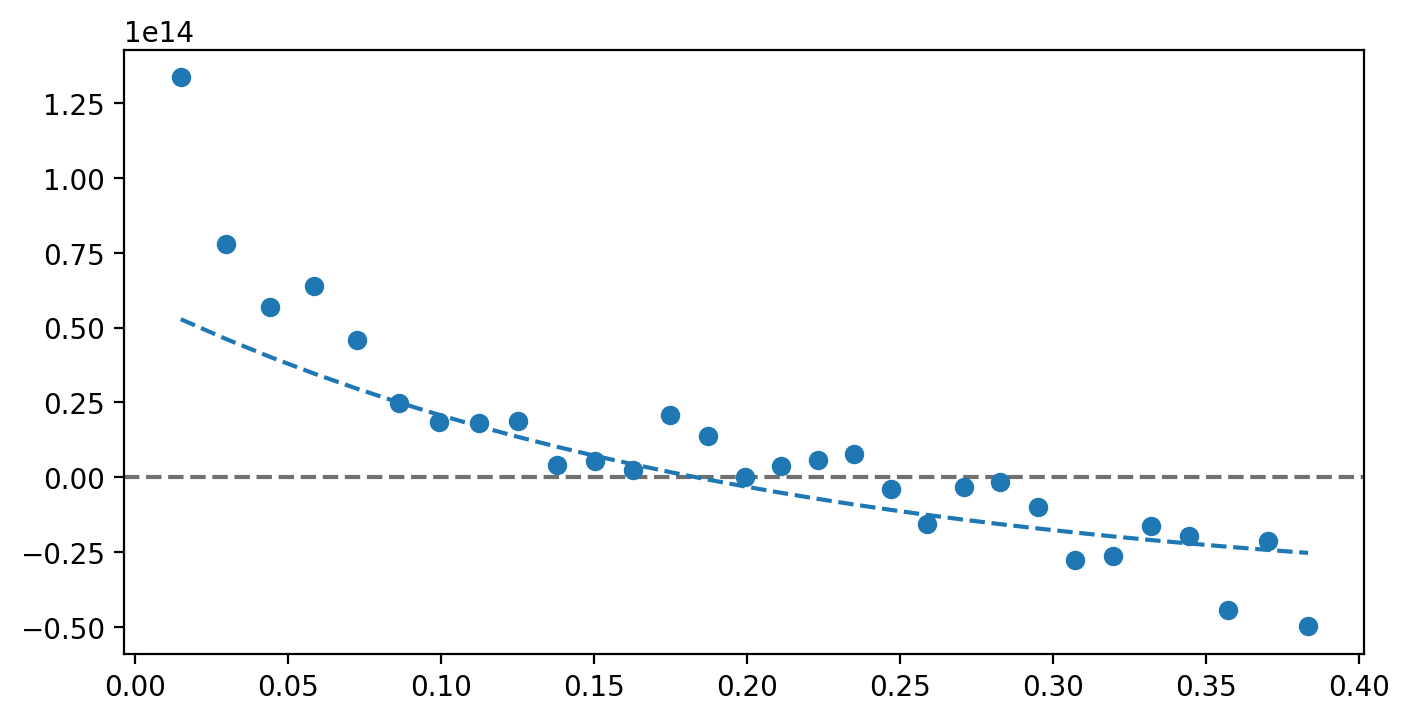

In [814]:
plt.scatter(x, y)
plt.axhline(0, linestyle='dashed', c='0.44', zorder=-10)
plt.plot(x, exponential(x, 1e7, 0.1, -0.4e14), linestyle='dashed')


In [816]:
def mse_kernel(x, y):
    def func(theta):
        alpha, rho, bias = theta
        #alpha, rho = 10*alpha, 10**rho
        yp = exponential(x, alpha, rho, bias)
        return np.mean((yp - y)**2) / np.var(y)
    return func
    
opt = minimize(mse_kernel(x, y), 
               x0=[1e7, 0.1, -0.4e14], 
               bounds=[(0, np.Inf), (0, np.Inf), (-np.Inf, np.Inf)], 
               #options={'ftol':1e-3, 'eps':1e-5},
               method='Nelder-Mead')
opt

 final_simplex: (array([[ 1.23738904e+07,  4.83179869e-02, -2.36882874e+13],
       [ 1.23738904e+07,  4.83179869e-02, -2.36882874e+13],
       [ 1.23738904e+07,  4.83179869e-02, -2.36882874e+13],
       [ 1.23738904e+07,  4.83179869e-02, -2.36882874e+13]]), array([0.12067507, 0.12067507, 0.12067507, 0.12067507]))
           fun: 0.12067506668680177
       message: 'Optimization terminated successfully.'
          nfev: 416
           nit: 193
        status: 0
       success: True
             x: array([ 1.23738904e+07,  4.83179869e-02, -2.36882874e+13])

Compare to scipy's `curve_fit()`:

In [818]:
params, param_covs = curve_fit(exponential, x, y, p0=[1e7, 0.1, -0.4e14])
params

array([ 1.23738059e+07,  4.83213775e-02, -2.36902929e+13])

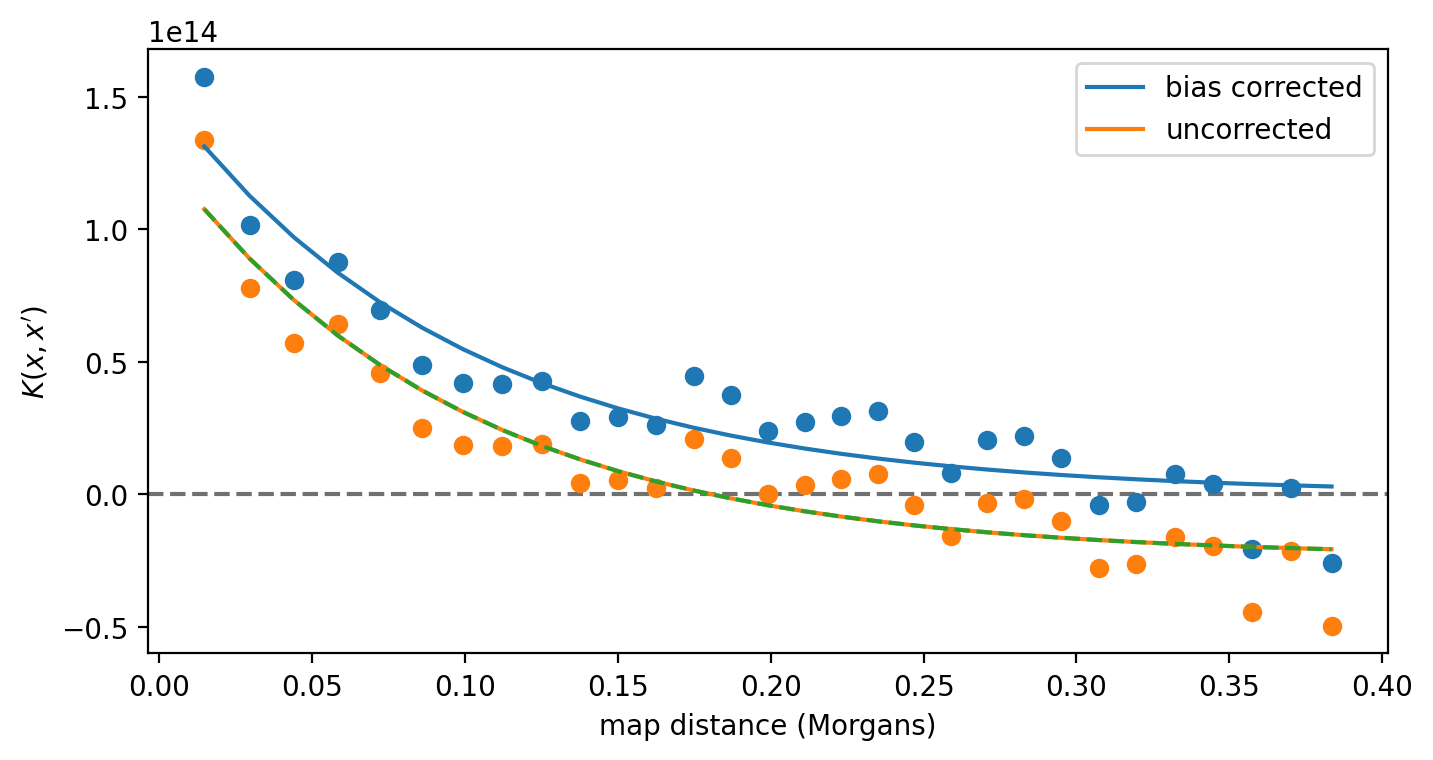

In [819]:
lines = plt.plot(x, exponential(x, *params) - params[2], label='bias corrected')
plt.scatter(x, y - params[2], c=lines[0].get_color())
lines = plt.plot(x, exponential(x, *params), label='uncorrected')
plt.scatter(x, y, c=lines[0].get_color())
plt.plot(x, exponential(x, *opt.x), linestyle='dashed')
plt.axhline(0, linestyle='dashed', c='0.44', zorder=-10)
plt.ylabel("$K(x, x')$")
plt.xlabel('map distance (Morgans)')
plt.legend()

Text(0.5, 0, 'map distance (Morgans)')

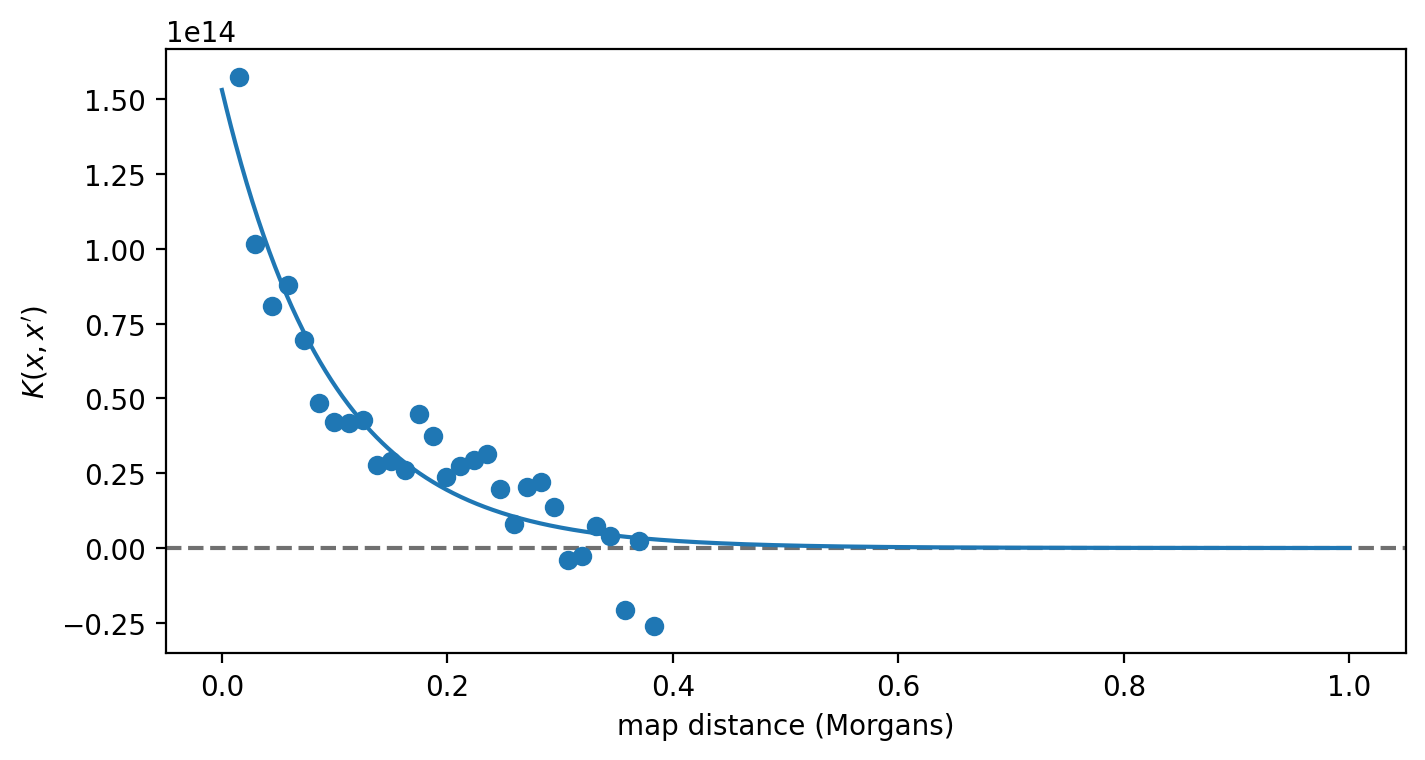

In [820]:
z = np.linspace(0, 1, 1000)
lines = plt.plot(z, exponential(z, *params) - params[2])
plt.scatter(x, y - params[2], c=lines[0].get_color())
plt.axhline(0, linestyle='dashed', c='0.44', zorder=-10)
plt.ylabel("$K(x, x')$")
plt.xlabel('map distance (Morgans)')

In [826]:
len(map_binsf)

2645

In [862]:
def predict_chromosome_covariances(mapbins, Y, kernel, bias=None):
    assert Y.shape[0] == len(mapbins), "len(mapbins) ≠ Y.shape[0]"
    chroms = np.array([c for c, _ in mapbins])
    all_chroms = list(set(chroms))
    Sigma = dict()
    for chrom in all_chroms:
        idx = chroms == chrom
        pi = pi_from_pairwise_summaries(Y[idx, :])
        N = Y[idx, :].sum(axis=1)
        Var = pi*(1-pi)*N
        pos = np.array([p for keep, (_, p) in zip(idx.tolist(), mapbins) if keep])
        assert pos.size == idx.sum()
        
        # compute the map distance matris for the kernel cov prediction
        pos_x, pos_y = np.meshgrid(pos, pos)    
        dist = np.abs(pos_x - pos_y)
        bias = bias if bias is not None else 0
        Cov = kernel(dist) - bias
        
        # fill in the diagonal with the proper variances
        #np.fill_diagonal(Cov, Var)    
        Sigma[chrom] = Cov
    return Sigma

fit_kernel = partial(exponential, alpha=params[0], rho=params[1], bias=params[2])

cms = predict_chromosome_covariances(map_binsf, Yf, fit_kernel)

In [863]:
def is_posdef(X):
    return np.all(np.linalg.eigvals(X) > 0)


is_posdef(cms['chr1'])

False

In [864]:
Sigma.max()

129420795422443.03

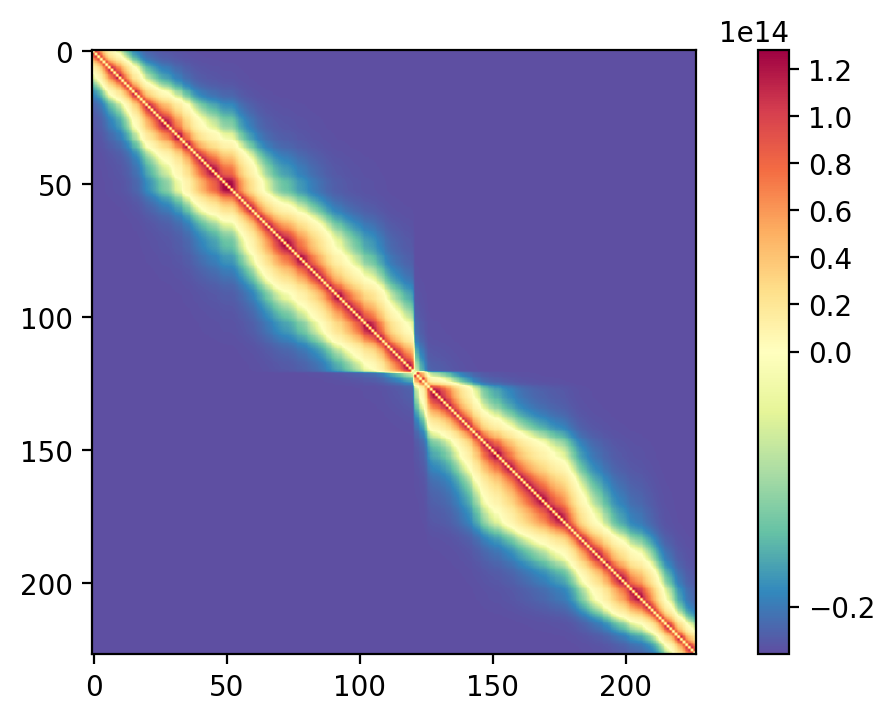

In [865]:
# without fixing bias (note color scale < 0):

Sigma = cms['chr1']

cmap = mpl.cm.get_cmap('Spectral_r')
norm = mpl.colors.TwoSlopeNorm(vmin=Sigma.min(), vcenter=0, vmax=Sigma.max())
cm = plt.imshow(Sigma, cmap=cmap, norm=norm)
plt.colorbar(cm, norm=norm)

In [866]:
Sigma

array([[ 1.54142965e+07,  1.01628708e+14,  7.94541908e+13, ...,
        -2.36902929e+13, -2.36902929e+13, -2.36902929e+13],
       [ 1.01628708e+14,  6.59779128e+07,  1.02328607e+14, ...,
        -2.36902929e+13, -2.36902929e+13, -2.36902929e+13],
       [ 7.94541908e+13,  1.02328607e+14,  5.01323113e+07, ...,
        -2.36902929e+13, -2.36902929e+13, -2.36902929e+13],
       ...,
       [-2.36902929e+13, -2.36902929e+13, -2.36902929e+13, ...,
         9.59811744e+07,  1.09178243e+14,  8.36615847e+13],
       [-2.36902929e+13, -2.36902929e+13, -2.36902929e+13, ...,
         1.09178243e+14,  8.86773310e+07,  1.00016656e+14],
       [-2.36902929e+13, -2.36902929e+13, -2.36902929e+13, ...,
         8.36615847e+13,  1.00016656e+14,  7.99459456e+07]])

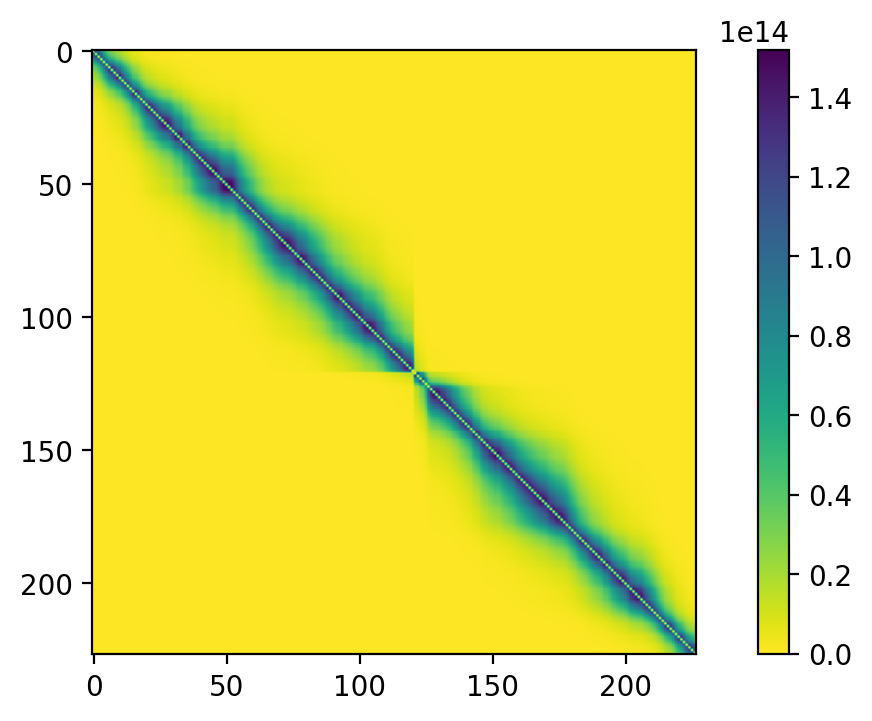

In [869]:
# with fixing bias:

cms = predict_chromosome_covariances(map_binsf, Yf, fit_kernel, bias=params[2])

Sigma = cms['chr1']
Sigma_nobias = Sigma

cmap = mpl.cm.get_cmap('viridis_r')
norm = mpl.colors.Normalize(vmin=0, vmax=Sigma_nobias.max())
cm = plt.imshow(Sigma_nobias, cmap=cmap, norm=norm)
plt.colorbar(cm, norm=norm)

In [756]:
# how much to offdiagonals contribute to the total? note this ignores the variance, e.g. Σ + σ^2 I 
(Sigma_nobias.sum() - np.diag(Sigma_nobias).sum()) / Sigma_nobias.sum()

0.9346622207866583

What's the scale of the normal approximation variance?

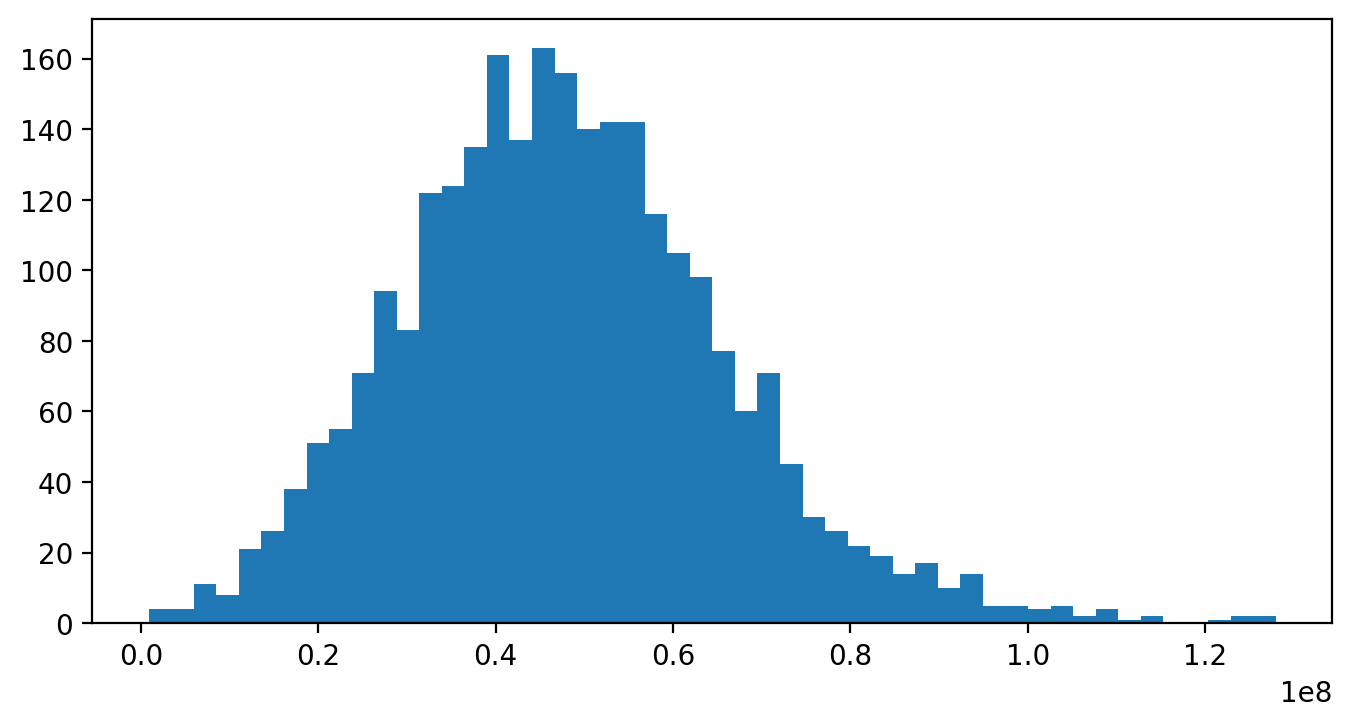

In [757]:
Nf = Yf.sum(axis = 1)
pif = pi_from_pairwise_summaries(Yf) 
_ = plt.hist(Nf * (1-pif)*pif, 50)

## Simulated Kernels

In [961]:
import tskit as ts
from bgspy.utils import bin_chrom

In [952]:
yri_1k = ts.load('../data/sim_kernels/3G09_chr1.ts')

In [1198]:
def sim_covariogram(ts, width, nlags=50, recmap=None):
    bins = bin_chrom(ts.sequence_length, int(width))
    pi = ts.diversity(windows=bins)/4 # since μ=1
    lags = list(range(1, 50))
    covs = []
    for lag in lags:
        covs.append(np.cov(pi[lag:], pi[:-lag])[0, 1])
    if recmap is not None:
        
    plt.scatter(lags, covs, label=f'width = {width}')
    return np.array(lags), np.array(covs)

## Genomic Covariogram and Variogram Estimators

In [ ]:
def covariogram(x, chroms, pos, max_lag=50):
    lags = list(range(1, max_lag))
    covs = []
    
    for lag in lags:
        covs.append(np.cov(pi[lag:], pi[:-lag])[0, 1])
    

In [1205]:
sim_gm_file = '/home/vsb/.cache/stdpopsim/genetic_maps/HomSap/HapMapII_GRCh37/genetic_map_GRCh37_chr1.txt'

from bgspy.recmap import RecMap

sim_gm = RecMap(sim_gm_file, {'chr1': yri_1k.sequence_length})

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)


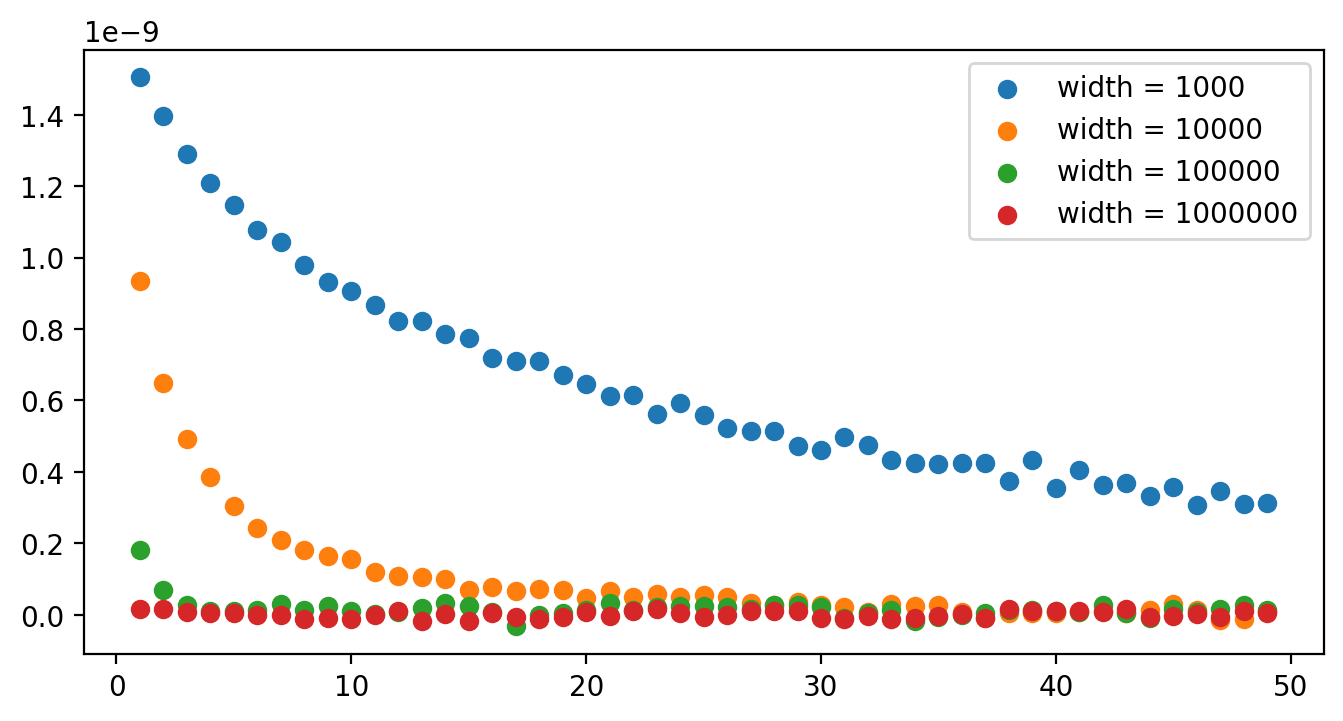

In [1203]:
sim_covariogram(yri_1k, 1_000)
sim_covariogram(yri_1k, 10_000)
sim_covariogram(yri_1k, 100_000)
sim_covariogram(yri_1k, 1_000_000)
plt.legend()

### Should We Control For Covariance?

In [1058]:
from scipy.linalg import toeplitz

In [1186]:
TK

array([[2.00000000e+00, 9.04837418e-01, 8.18730753e-01, ...,
        6.12834951e-05, 5.54515994e-05, 5.01746821e-05],
       [9.04837418e-01, 2.00000000e+00, 9.04837418e-01, ...,
        6.77287365e-05, 6.12834951e-05, 5.54515994e-05],
       [8.18730753e-01, 9.04837418e-01, 2.00000000e+00, ...,
        7.48518299e-05, 6.77287365e-05, 6.12834951e-05],
       ...,
       [6.12834951e-05, 6.77287365e-05, 7.48518299e-05, ...,
        2.00000000e+00, 9.04837418e-01, 8.18730753e-01],
       [5.54515994e-05, 6.12834951e-05, 6.77287365e-05, ...,
        9.04837418e-01, 2.00000000e+00, 9.04837418e-01],
       [5.01746821e-05, 5.54515994e-05, 6.12834951e-05, ...,
        8.18730753e-01, 9.04837418e-01, 2.00000000e+00]])

In [1191]:
n = 100
z = np.arange(n)
MU = np.sin(z/5) 
#MU = z
TK = exponential(toeplitz(range(n)), 1, 5) + 0.1*np.eye(n) 


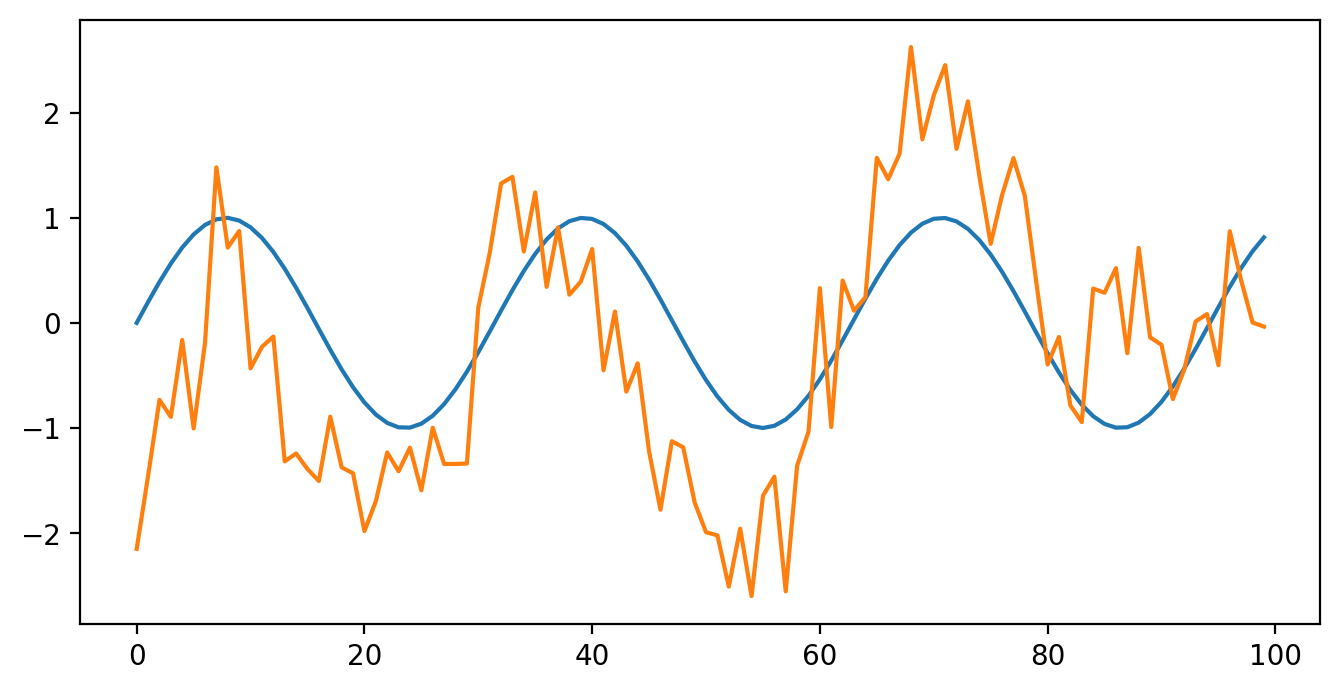

In [1192]:
plt.plot(MU)
plt.plot(np.random.multivariate_normal(MU, TK))
#plt.plot(np.random.multivariate_normal(MU, np.eye(n)))

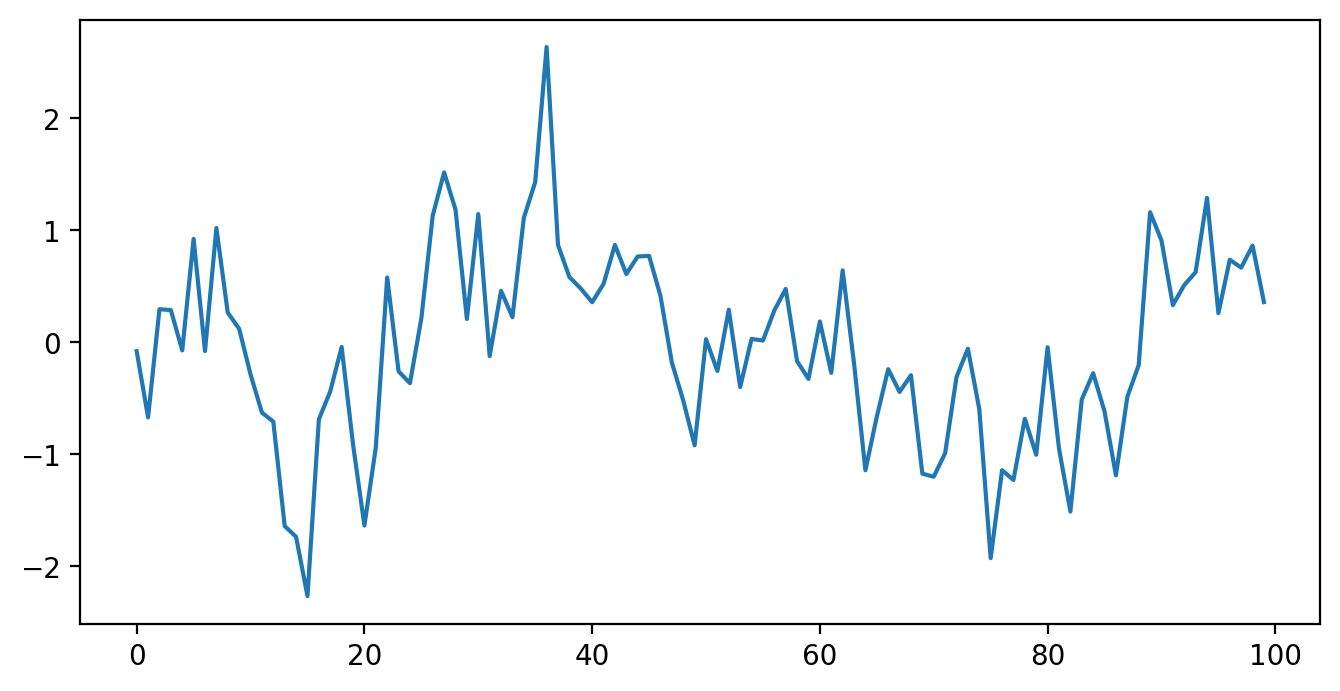

In [1195]:
plt.plot((np.random.multivariate_normal(MU, TK) - MU))

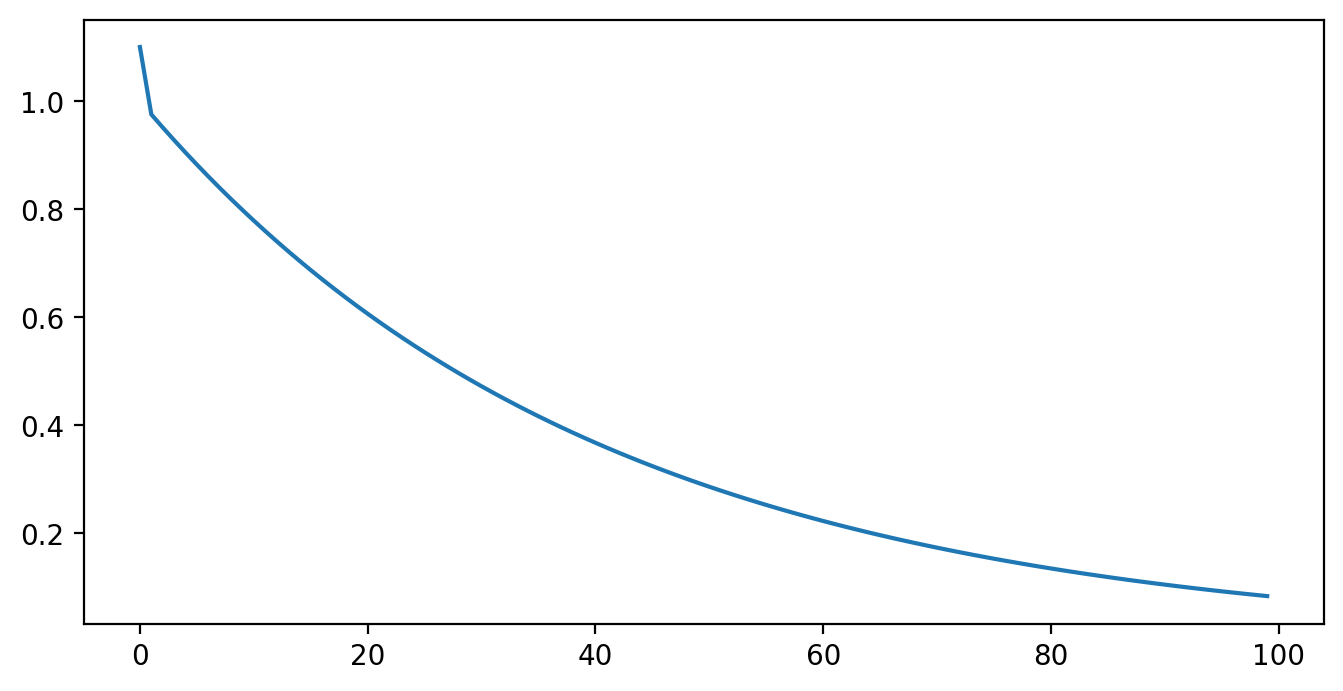

In [1144]:
plt.plot(TK[0,:])